# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

## 0. Parameters <a name="parameters"></a>

In [2]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "../../../notebooks/11_music/01_transformer/parsed_data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 50
BATCH_SIZE = 256

GENERATE_LEN = 50

In [3]:
env = music21.environment.UserSettings()
env["musicxmlPath"] = "C:\\Program Files\\WindowsApps\\64051MuseScoreBVBA.MuseScoreNotationSoftware_3.3.4.0_x64__pz631wrhsw9tj\\bin\\MuseScore3.exe"
env["musescoreDirectPNGPath"] = "C:\\Program Files\\WindowsApps\\64051MuseScoreBVBA.MuseScoreNotationSoftware_3.3.4.0_x64__pz631wrhsw9tj\\bin\\MuseScore3.exe"
for key in env.keys():
    print(key, env[key])

directoryScratch None
lilypondPath C:\Users\Asus\git\Generative_Deep_Learning_2nd_Edition\notebooks\11_music\01_transformer\lilypond
lilypondVersion None
lilypondFormat pdf
lilypondBackend ps
musicxmlPath C:\Program Files\WindowsApps\64051MuseScoreBVBA.MuseScoreNotationSoftware_3.3.4.0_x64__pz631wrhsw9tj\bin\MuseScore3.exe
midiPath None
graphicsPath None
vectorPath None
pdfPath None
braillePath None
musescoreDirectPNGPath C:\Program Files\WindowsApps\64051MuseScoreBVBA.MuseScoreNotationSoftware_3.3.4.0_x64__pz631wrhsw9tj\bin\MuseScore3.exe
showFormat musicxml
writeFormat musicxml
ipythonShowFormat ipython.musicxml.png
autoDownload ask
debug 0
warnings 1
localCorpusSettings LocalCorpusSettings([])
localCorporaSettings {}
manualCoreCorpusPath None
localCorpusPath None


## 1. Prepare the Data

In [4]:
# Load the data
file_list = glob.glob("../../../data/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [5]:
parser = music21.converter

In [6]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

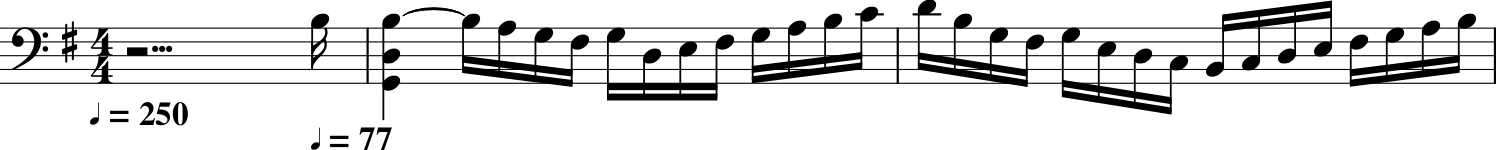

In [7]:
example_score.show()

In [8]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x20f0de06400>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250.0>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77.0>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>

In [9]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing ../../../data/bach-cello\cs1-1pre.mid
658 notes parsed
2 Parsing ../../../data/bach-cello\cs1-2all.mid
1579 notes parsed
3 Parsing ../../../data/bach-cello\cs1-3cou.mid
2399 notes parsed
4 Parsing ../../../data/bach-cello\cs1-4sar.mid
2662 notes parsed
5 Parsing ../../../data/bach-cello\cs1-5men.mid
3309 notes parsed
6 Parsing ../../../data/bach-cello\cs1-6gig.mid
3735 notes parsed
7 Parsing ../../../data/bach-cello\cs2-1pre.mid
4373 notes parsed
8 Parsing ../../../data/bach-cello\cs2-2all.mid
5070 notes parsed
9 Parsing ../../../data/bach-cello\cs2-3cou.mid
5811 notes parsed
10 Parsing ../../../data/bach-cello\cs2-4sar.mid
6148 notes parsed
11 Parsing ../../../data/bach-cello\cs2-5men.mid
6675 notes parsed
12 Parsing ../../../data/bach-cello\cs2-6gig.mid
7410 notes parsed
13 Parsing ../../../data/bach-cello\cs3-1pre.mid
8391 notes parsed
14 Parsing ../../../data/bach-cello\cs3-2all.mid
9128 notes parsed
15 Parsing ../../../data/bach-cello\cs3-3cou.mid
10117 notes parsed
16 P

In [10]:
example_notes = notes[658]
example_durations = durations[658]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 START G:major 4/4TS rest B3 B3 B3 A3 G3 F#3 G3 D3 E3 F#3 G3 A3 B3 C4 D4 B3 G3 F#3 G3 E3 D3 C3 B2 C3 D3 E3 F#3 G3 A3 B3 C4 A3 G3 F#3 G3 E3 F#3 G3 A2 D3 F#3 G3 A3 B3 C4 A3 B3 ...

Duration string
 0.0 0.0 0.0 3.75 0.25 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## 2. Tokenize the data <a name="tokenize"></a>

In [11]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [12]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        37        10
        51        10
        42        10
        27        18
         9         2
         9         4
         9         2
         3         2
         2         2
        12         2
         2         2


In [13]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [14]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [15]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9, 17,  7, ..., 17,  7, 36],
       [17,  7, 16, ...,  7, 36, 36],
       [ 7, 16, 18, ..., 36, 36, 36],
       ...,
       [ 9, 17,  3, ...,  4,  8, 12],
       [17,  3,  9, ...,  8, 12,  2],
       [ 3,  9, 17, ..., 12,  2,  3]], dtype=int64)>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[2, 4, 2, ..., 2, 2, 2],
       [4, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 3, 4, ..., 2, 6, 2],
       [3, 4, 2, ..., 6, 2, 6],
       [4, 2, 2, ..., 2, 6, 2]], dtype=int64)>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[17,  7, 16, ...,  7, 36, 36],
       [ 7, 16, 18, ..., 36, 36, 36],
       [16, 18,  8, ..., 36, 36,  8],
       ...,
       [17,  3,  9, ...,  8, 12,  2],
       [ 3,  9, 17, ..., 12,  2,  3],
       [ 9, 17,  7, ...,  2,  3,  9]], dtype=int64)>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[4, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
    

## 5. Create the causal attention mask function <a name="causal"></a>

In [16]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [17]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [18]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

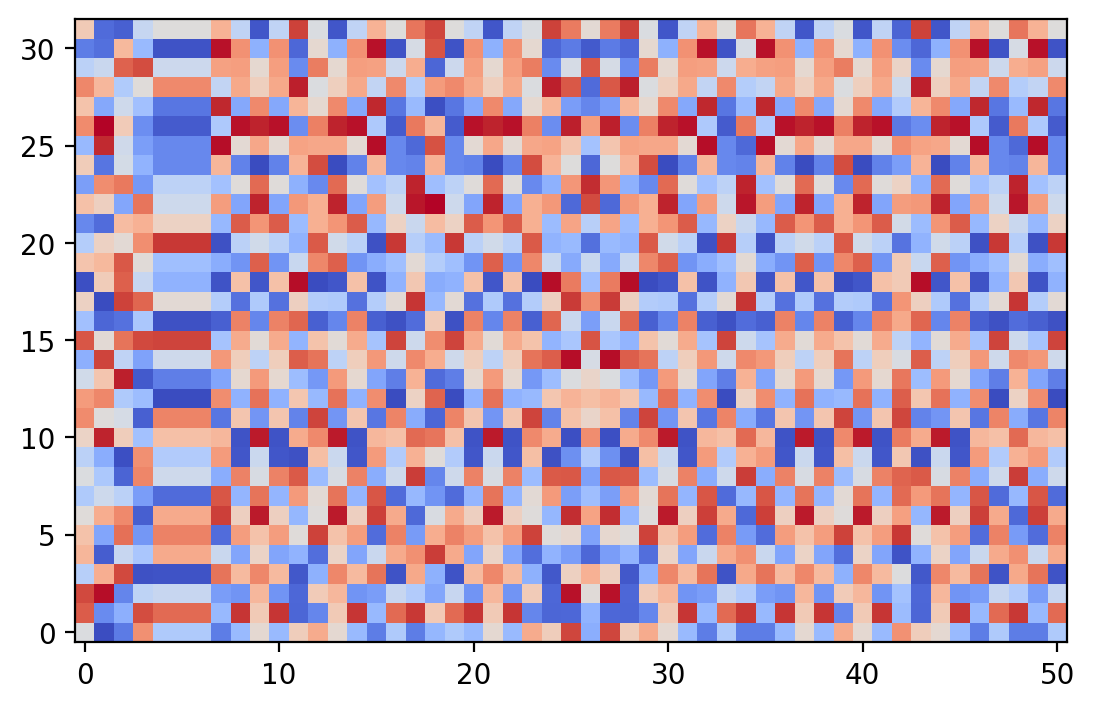

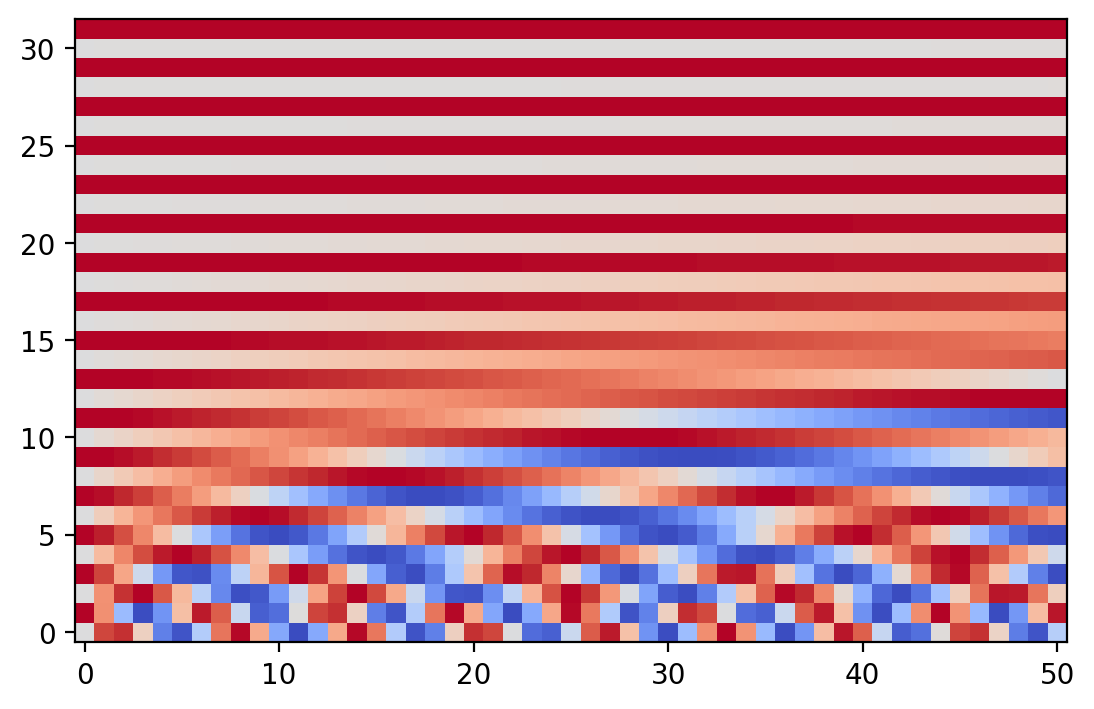

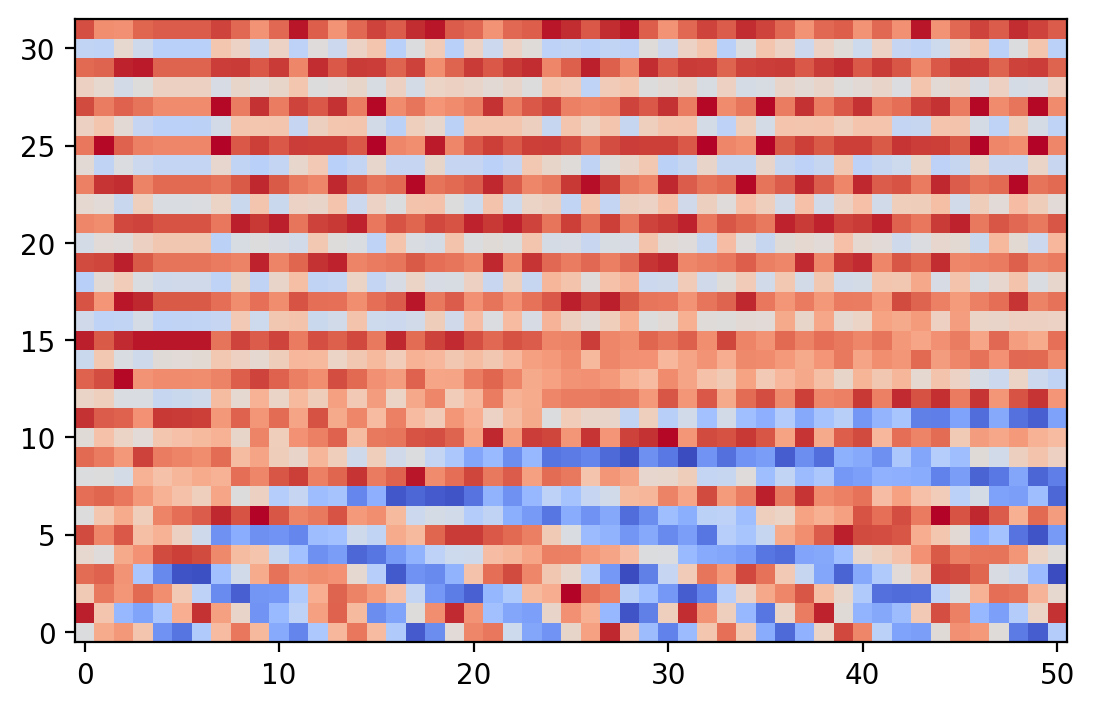

In [19]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [20]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, None, 128)   7552        ['input_1[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 token_and_position_embedding_2  (None, None, 128)   3072        ['input_2[0][0]']            

In [22]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [23]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "../../../notebooks/11_music/01_transformer/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [24]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

Epoch 1/50
[['START', 'D3', 'C3', 'B-3', 'C3', 'G3', 'A3', 'F3', 'G3', 'F3', 'D3', 'C3', 'E-3', 'G#3', 'D3', 'B-3', 'G3', 'F3', 'F3', 'F3', 'D4', 'D3', 'D3', 'G#3', 'G3', 'F3', 'F3', 'C3', 'F3', 'F3', 'F3', 'E-3', 'D3', 'G3', 'G3', 'F3', 'G3', 'F3', 'F3', 'E-3', 'D4', 'D3', 'E-3', 'F3', 'C3', 'D3', 'E-3', 'C3', 'E-3'], ['0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


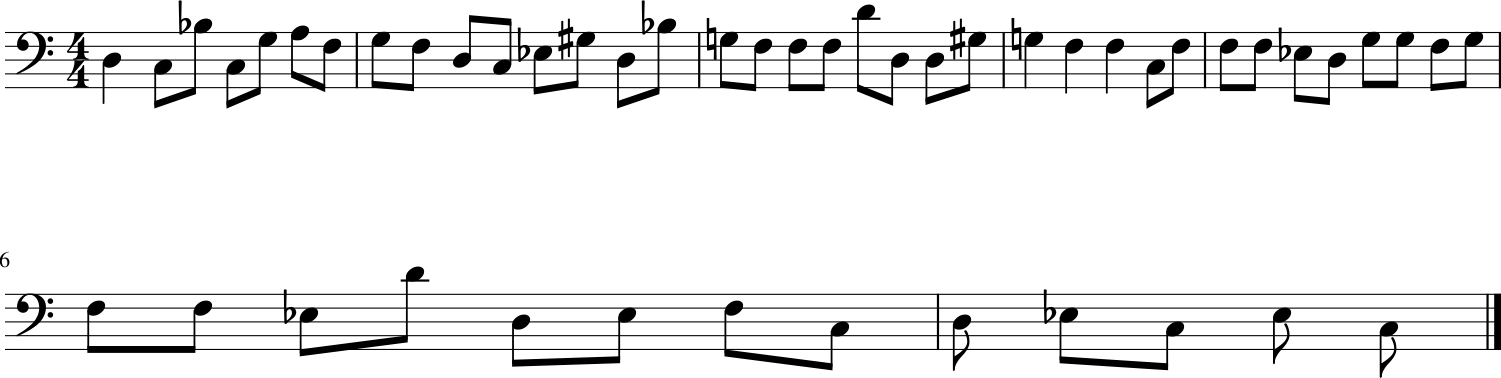

108/108 [==============================] - 18s 143ms/step - loss: 4.6566 - note_outputs_loss: 3.4980 - duration_outputs_loss: 1.1586
Epoch 2/50
[['START', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'E-3', 'D3', 'B2', 'D3', 'C3', 'D3', 'B2', 'D3', 'C3', 'E-3', 'E3', 'D3', 'D3', 'D3', 'D3', 'D3', 'F3', 'B2', 'F#3', 'D3', 'G3', 'F#3', 'G3', 'D3', 'E3', 'D3', 'D3', 'D3', 'E-3', 'D3', 'G3', 'D3', 'E3', 'D3', 'F3', 'E3', 'D3', 'D3', 'D3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


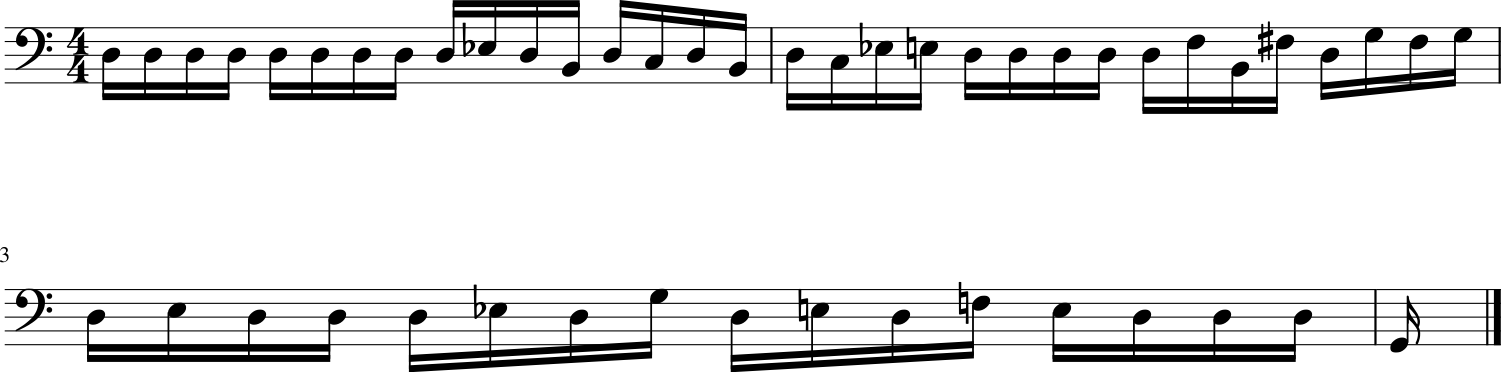

108/108 [==============================] - 15s 136ms/step - loss: 4.0480 - note_outputs_loss: 3.2638 - duration_outputs_loss: 0.7842
Epoch 3/50
[['START', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'G2', 'E-3', 'F3', 'E3', 'F3', 'E3', 'F3', 'E3', 'F3', 'E-3', 'F3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'E3', 'D3', 'F3', 'E3', 'D3', 'C3', 'D3', 'B-2', 'C3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


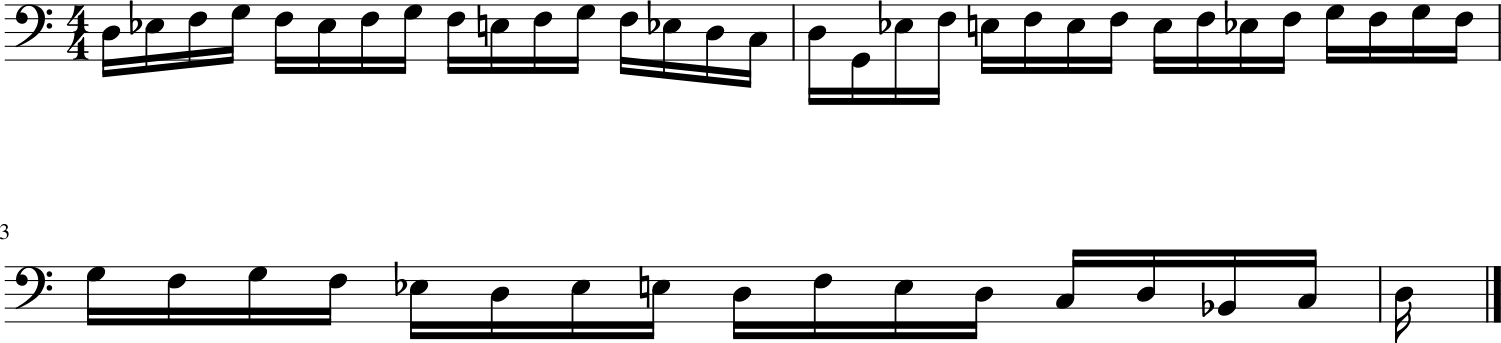

108/108 [==============================] - 15s 136ms/step - loss: 3.6097 - note_outputs_loss: 2.9373 - duration_outputs_loss: 0.6724
Epoch 4/50
[['START', 'C3', 'C3', 'B-2', 'C3', 'B-2', 'C3', 'G2', 'F2', 'G2', 'C3', 'B-2', 'C3', 'G2', 'G2', 'C3', 'C3', 'G2', 'C3', 'B-2', 'C3', 'G2', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'B-2', 'F3', 'C3', 'G2', 'C3', 'A3', 'D3', 'G3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


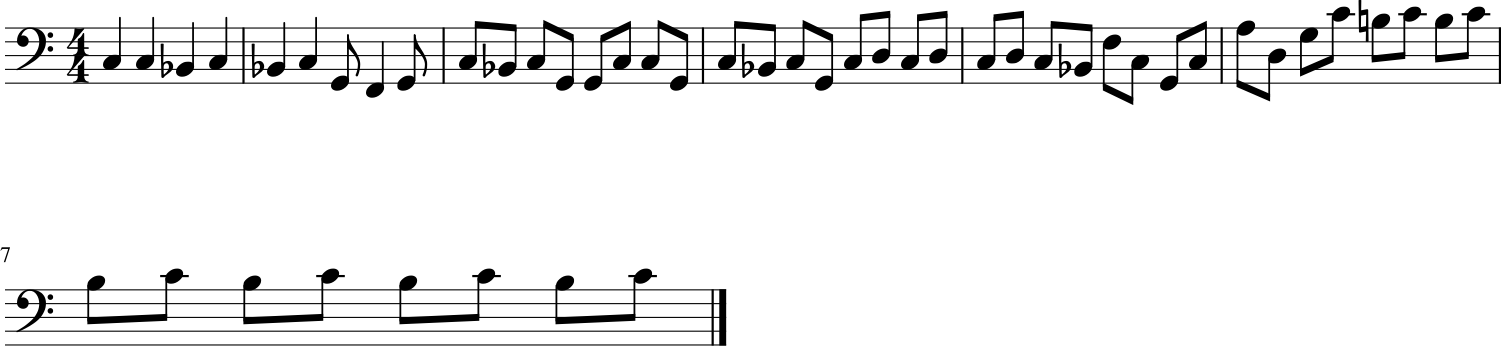

108/108 [==============================] - 15s 135ms/step - loss: 3.3848 - note_outputs_loss: 2.7357 - duration_outputs_loss: 0.6491
Epoch 5/50
[['START', '4/4TS', '3/4TS', 'G2', 'A2', 'A2', 'F2', 'E2', 'A2', 'B2', 'A2', 'A2', 'D3', 'C3', 'D3', 'C#3', 'D3', 'E3', 'F3', 'D3', 'C3', 'D3', 'E3', 'D3', 'C3', 'D3', 'C3', 'B2', 'C3', 'A2', 'A2', 'G2', 'B2', 'C3', 'B2', 'A2', 'A2', 'C3', 'D3', 'A2', 'B2', 'A2', 'A2', 'D3', 'B-2', 'A2', 'E2', 'A2', 'C3'], ['0.0', '0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


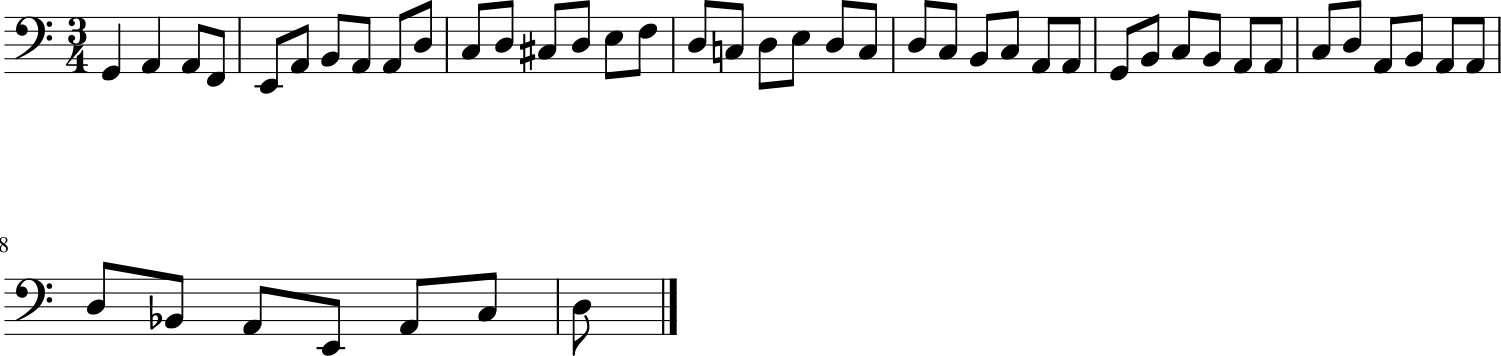

108/108 [==============================] - 15s 135ms/step - loss: 3.2450 - note_outputs_loss: 2.6265 - duration_outputs_loss: 0.6185
Epoch 6/50
[['START', '3/4TS', 'F2', 'G#2', 'G#2', 'E-2', 'F#2', 'F2', 'G2', 'E3', 'F3', 'D3', 'B2', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'F3', 'E3', 'F3', 'G3', 'F3', 'E3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'F3', 'D3', 'C#3', 'D3', 'E3', 'F3'], ['0.0', '0.0', '2.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


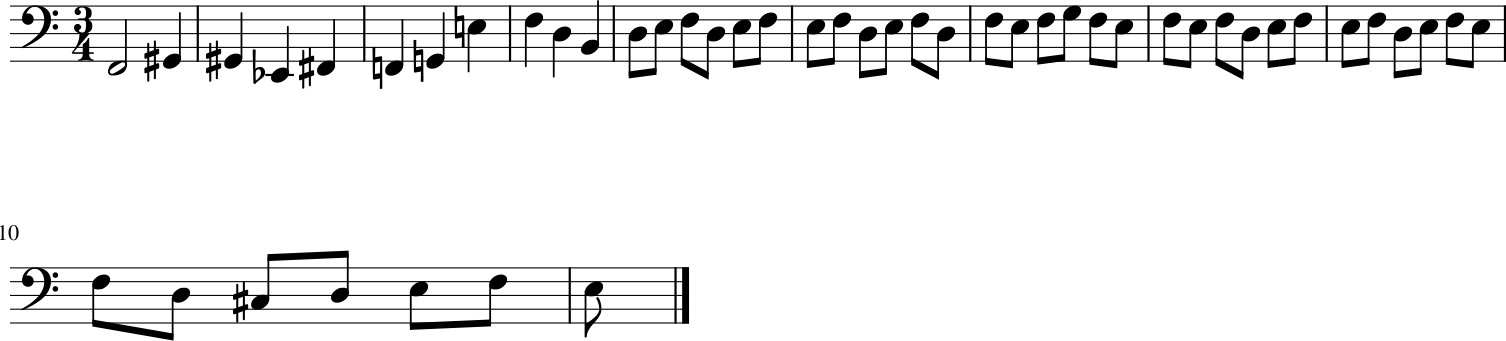

108/108 [==============================] - 15s 138ms/step - loss: 3.1482 - note_outputs_loss: 2.5476 - duration_outputs_loss: 0.6006
Epoch 7/50
[['START', '4/4TS', '4/4TS', '3/4TS'], ['0.0', '0.0', '0.0', '0.0']]note_outputs_loss: 2.5065 - duration_outputs_loss: 0.5873 


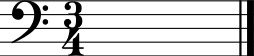

108/108 [==============================] - 10s 86ms/step - loss: 3.0938 - note_outputs_loss: 2.5065 - duration_outputs_loss: 0.5873
Epoch 8/50
[['START', 'F:major', '3/4TS'], ['0.0', '0.0', '0.0']]oss: 3.0647 - note_outputs_loss: 2.4774 - duration_outputs_loss: 0.5873 


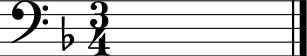

108/108 [==============================] - 9s 86ms/step - loss: 3.0647 - note_outputs_loss: 2.4774 - duration_outputs_loss: 0.5873
Epoch 9/50
[['START', '3/4TS', '4/4TS', 'D4', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'A3', 'A3', 'B3', 'A3', 'A3', 'G3', 'A3', 'B3', 'A3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'C#4', 'D4', 'E4', 'D4', 'E4', 'D4', 'C#4', 'E4', 'C#4', 'A3', 'E4', 'E4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'E4', 'E4', 'C#4', 'E4', 'D4', 'C#4', 'D4'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


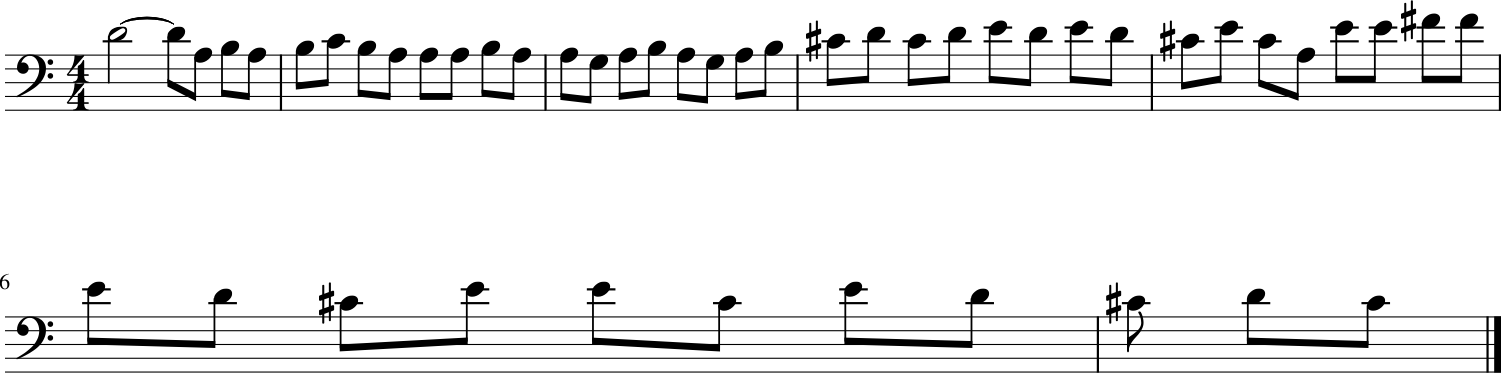

108/108 [==============================] - 15s 137ms/step - loss: 3.0225 - note_outputs_loss: 2.4410 - duration_outputs_loss: 0.5815
Epoch 10/50
[['START', '4/4TS', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'F3', 'E-3', 'B2', 'C3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3', 'F3', 'E-3', 'G3', 'G#3', 'F3', 'G3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'G#3', 'B-3', 'G#3'], ['0.0', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '0.25', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12']]


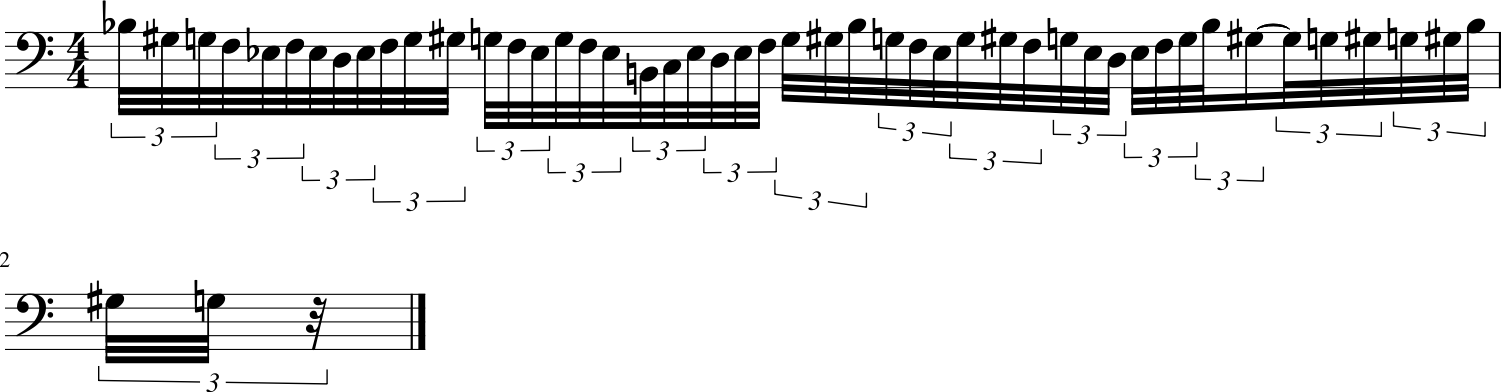

108/108 [==============================] - 15s 138ms/step - loss: 3.0172 - note_outputs_loss: 2.4292 - duration_outputs_loss: 0.5881
Epoch 11/50
[['START', '4/4TS', '4/4TS', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'C3', 'B-2', 'G#2', 'B-3', 'G#3', 'G#3', 'G3', 'G#3', 'F3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'F3', 'E-3', 'D3', 'B-2', 'G#2', 'G2', 'B-2', 'G#2', 'B-2', 'G#2', 'G2', 'B-2', 'E-2', 'B-2'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


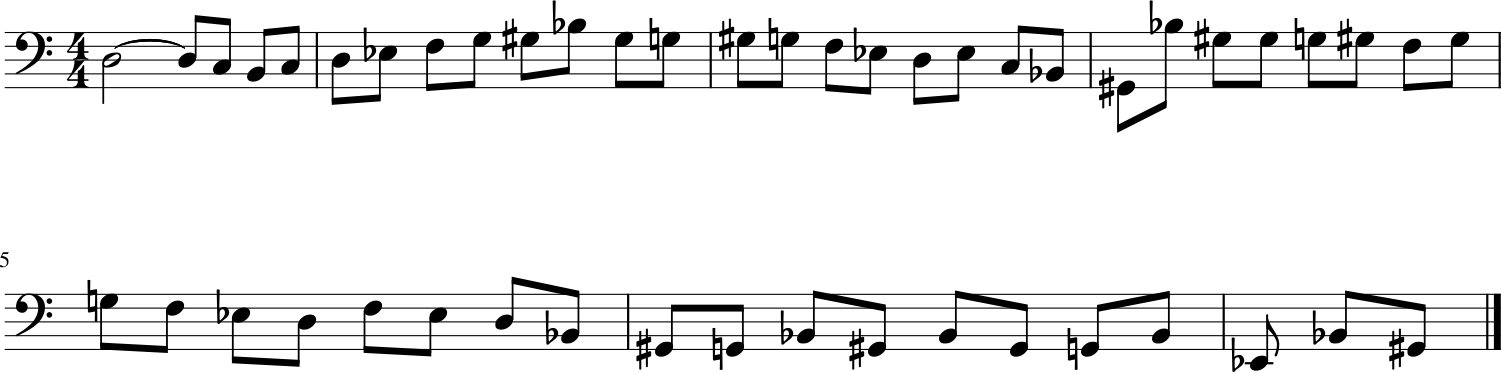

108/108 [==============================] - 15s 139ms/step - loss: 2.9850 - note_outputs_loss: 2.4086 - duration_outputs_loss: 0.5765
Epoch 12/50
[['START', '4/4TS', '4/4TS', '4/4TS', 'rest'], ['0.0', '0.0', '0.0', '0.0', '3.75']]s: 2.3931 - duration_outputs_loss: 0.5694 


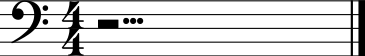

108/108 [==============================] - 10s 87ms/step - loss: 2.9625 - note_outputs_loss: 2.3931 - duration_outputs_loss: 0.5694
Epoch 13/50
[['START', '4/4TS', 'C:major', '3/4TS', 'G3', 'A3', 'B3', 'A3', 'G#3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'A3', 'F#3', 'G3', 'F#3', 'A3', 'F#3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'D3', 'E3', 'F#3', 'G3', 'F#3'], ['0.0', '0.0', '0.0', '0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


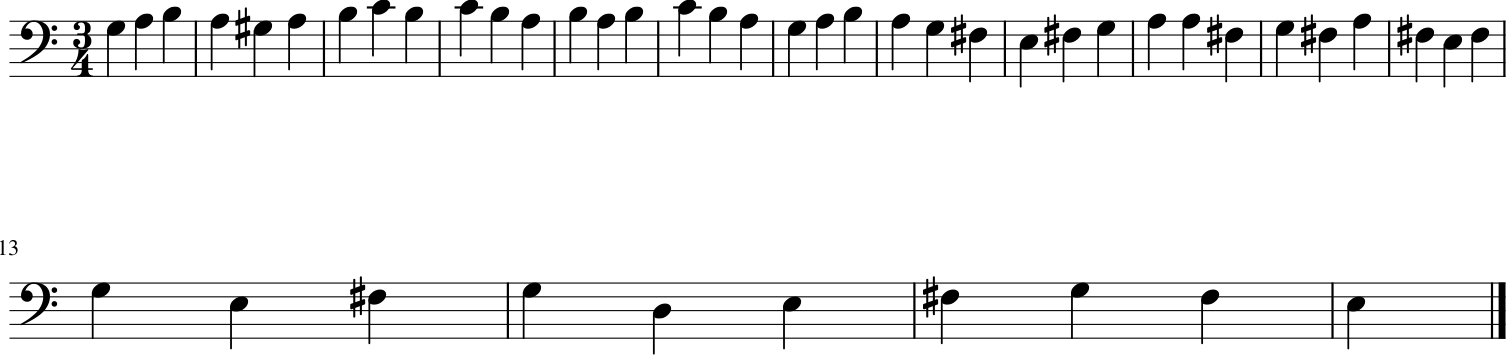

108/108 [==============================] - 15s 138ms/step - loss: 2.9185 - note_outputs_loss: 2.3607 - duration_outputs_loss: 0.5579
Epoch 14/50
[['START', '3/4TS', 'rest', 'A3', 'D3', 'C4', 'A3', 'B3', 'A3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'A3', 'G3', 'A3', 'F3', 'E3', 'D3', 'F3', 'D3', 'E3', 'E3', 'D3', 'F3', 'E3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'G3', 'F3', 'E-3', 'F3', 'D3', 'C3', 'B2', 'C3'], ['0.0', '0.0', '3.75', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/6', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12', '1/12']]


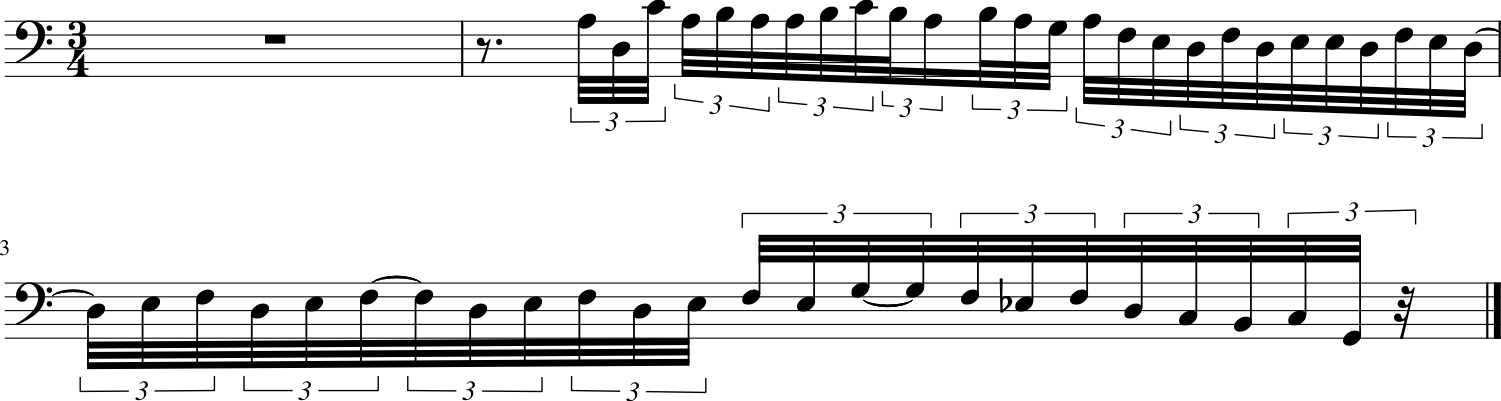

108/108 [==============================] - 16s 141ms/step - loss: 2.9163 - note_outputs_loss: 2.3473 - duration_outputs_loss: 0.5690
Epoch 15/50
[['START', 'E-:major', '3/4TS', 'D3', 'E-3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'D3', 'C3', 'D3', 'C3', 'D3', 'E-3', 'F3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'F3', 'E-3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3', 'C3', 'D3'], ['0.0', '2.5', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


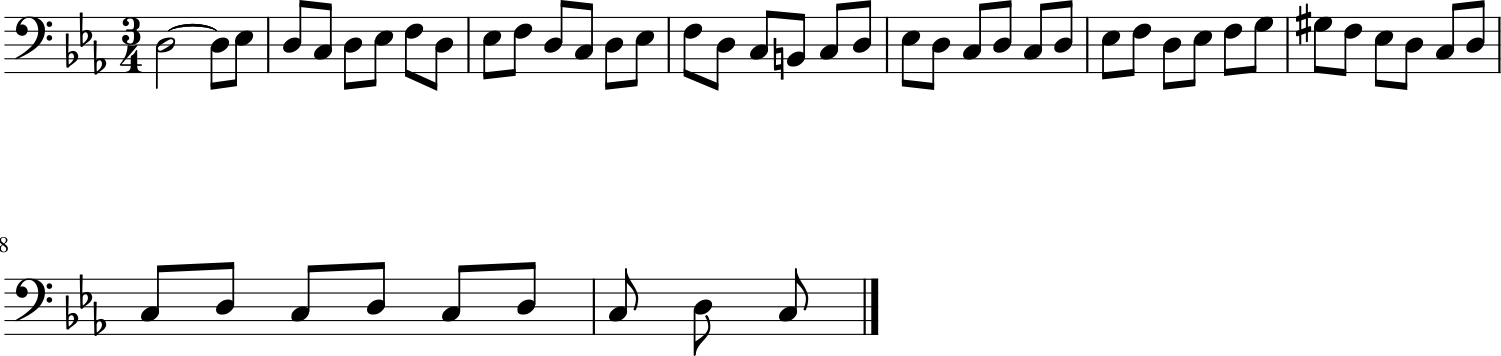

108/108 [==============================] - 16s 146ms/step - loss: 2.8852 - note_outputs_loss: 2.3211 - duration_outputs_loss: 0.5642
Epoch 16/50
[['START', '4/4TS', '4/4TS', 'F#4', 'G4', 'G4', 'G4', 'G4', 'F#4', 'E4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'E4', 'E4', 'F#4', 'G4', 'E4', 'F#4', 'G4', 'G4', 'G4', 'F#4', 'E4', 'E4', 'E4', 'E4', 'F#4', 'G4', 'F#4', 'C#4', 'E4', 'E4', 'F#4', 'E4', 'E4', 'E4', 'C#4', 'E4', 'G4', 'F#4', 'E4', 'F#4'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


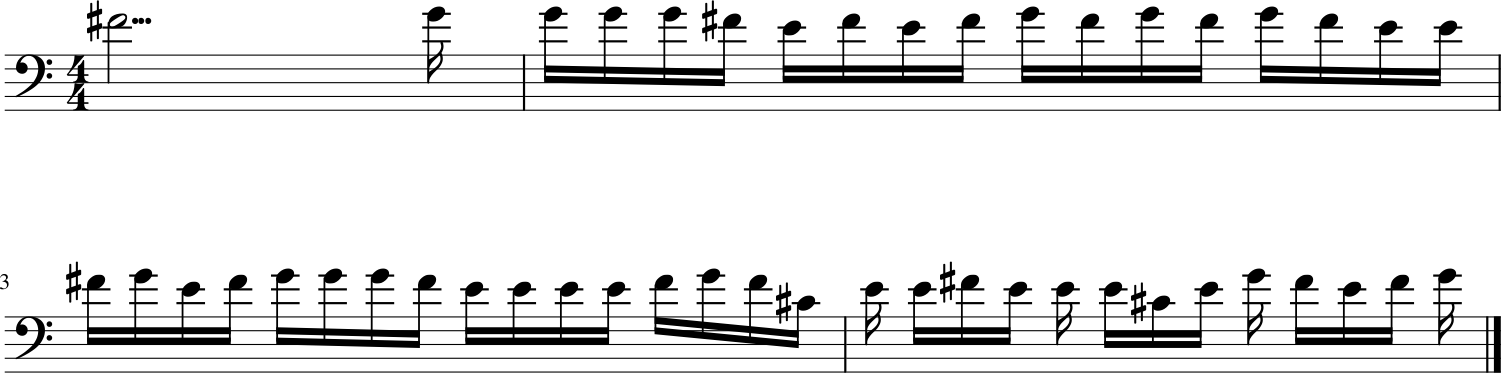

108/108 [==============================] - 16s 149ms/step - loss: 2.8852 - note_outputs_loss: 2.3102 - duration_outputs_loss: 0.5750
Epoch 17/50
[['START', '4/4TS', 'rest', 'C#4', 'C#4', 'C#4', 'C#4', 'B3', 'E4', 'F#4', 'G4', 'E4', 'E4', 'C#4', 'E4', 'D4', 'C#4', 'B3', 'C#4', 'C#4', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'F#3', 'E3', 'D3', 'F#3', 'E3', 'F#3', 'F#3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'B3'], ['0.0', '0.0', '5.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


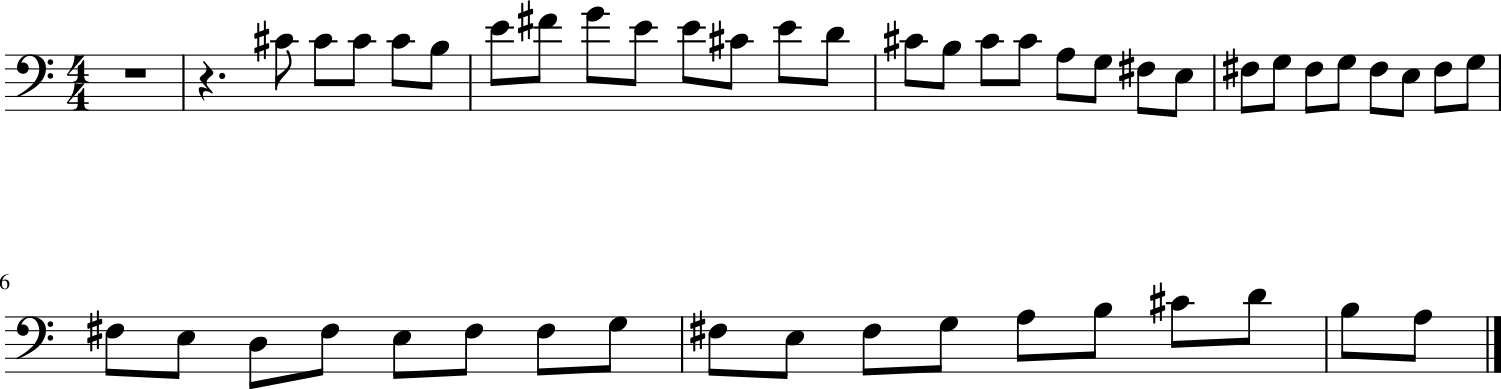

108/108 [==============================] - 16s 145ms/step - loss: 2.8699 - note_outputs_loss: 2.3095 - duration_outputs_loss: 0.5605
Epoch 18/50
[['START', '3/4TS', 'rest', 'D4', 'rest'], ['0.0', '0.0', '3.75', '0.25', '0.25']]oss: 2.2858 - duration_outputs_loss: 0.5578 


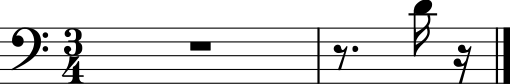

108/108 [==============================] - 10s 91ms/step - loss: 2.8435 - note_outputs_loss: 2.2858 - duration_outputs_loss: 0.5578
Epoch 19/50
[['START', '4/4TS', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '5.5']] note_outputs_loss: 2.2699 - duration_outputs_loss: 0.5606 


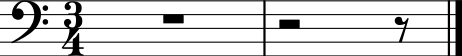

108/108 [==============================] - 10s 89ms/step - loss: 2.8305 - note_outputs_loss: 2.2699 - duration_outputs_loss: 0.5606
Epoch 20/50
[['START', '4/4TS', 'rest', 'D4', 'rest', 'D4', 'C4', 'B3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'E4', 'F#4', 'G4', 'F#4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'E4', 'E4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'G4', 'F#4', 'E4', 'D4', 'C#4', 'B3', 'A3', 'B3', 'C#4', 'D4'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


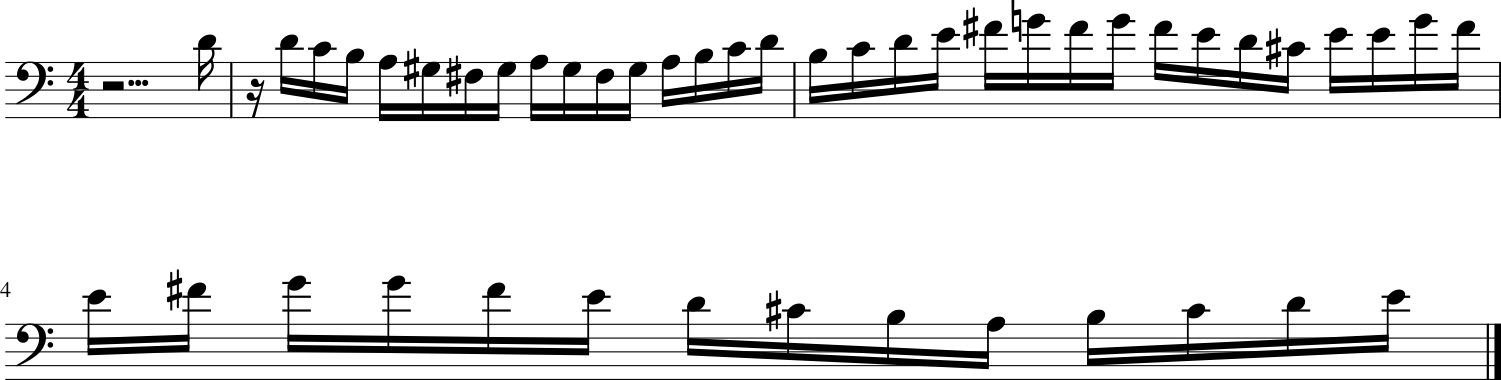

108/108 [==============================] - 15s 142ms/step - loss: 2.8284 - note_outputs_loss: 2.2563 - duration_outputs_loss: 0.5721
Epoch 21/50
[['START', '4/4TS', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '2.75']]note_outputs_loss: 2.2465 - duration_outputs_loss: 0.5522 


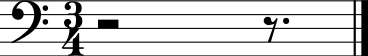

108/108 [==============================] - 10s 86ms/step - loss: 2.7988 - note_outputs_loss: 2.2465 - duration_outputs_loss: 0.5522
Epoch 22/50
[['START', '4/4TS', '3/4TS', 'rest'], ['0.0', '0.0', '0.0', '0.5']] note_outputs_loss: 2.2303 - duration_outputs_loss: 0.5691 


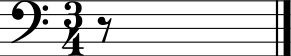

108/108 [==============================] - 9s 86ms/step - loss: 2.7994 - note_outputs_loss: 2.2303 - duration_outputs_loss: 0.5691
Epoch 23/50
[['START', '4/4TS', '4/4TS', 'rest', 'C4', 'B-3', 'E-4', 'B-3', 'C4', 'B-3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'B-2', 'C3', 'G#2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'F3', 'E-3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


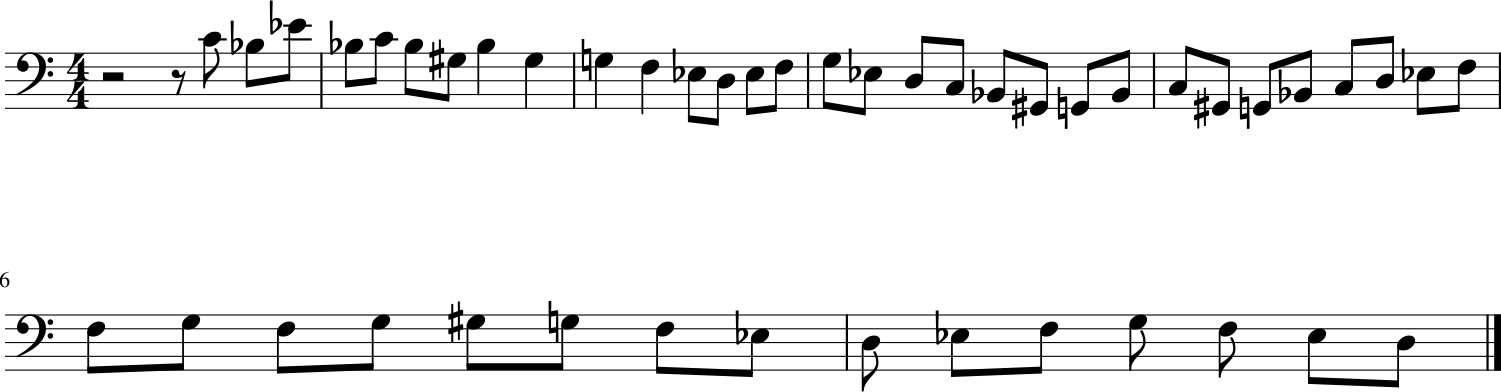

108/108 [==============================] - 15s 135ms/step - loss: 2.7588 - note_outputs_loss: 2.2047 - duration_outputs_loss: 0.5541
Epoch 24/50
[['START', '4/4TS', 'rest', 'A4', 'rest', 'A4', 'A4', 'rest', 'A4', 'A4', 'rest', 'A4', 'rest', 'A4', 'A4', 'A4', 'B4', 'A4', 'A4', 'F#4', 'F#4', 'F#4', 'F#4', 'G4', 'G4', 'F#4', 'B4', 'A4', 'F#4', 'G4', 'F#4', 'E4', 'F#4', 'G4', 'F#4', 'F#4', 'G4', 'F#4', 'F#4', 'E4', 'D4', 'E4', 'F#4', 'D4', 'B3', 'A3', 'B3', 'A3', 'B3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


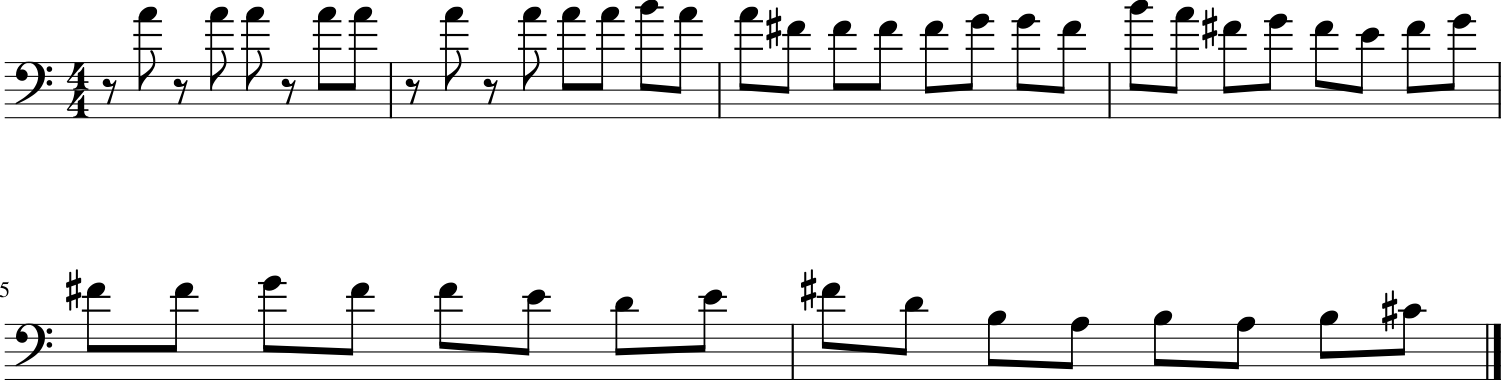

108/108 [==============================] - 15s 135ms/step - loss: 2.7558 - note_outputs_loss: 2.1990 - duration_outputs_loss: 0.5568
Epoch 25/50
[['START', '3/4TS', 'rest'], ['0.0', '0.0', '3.75']] loss: 2.7393 - note_outputs_loss: 2.1900 - duration_outputs_loss: 0.5493 


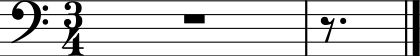

108/108 [==============================] - 9s 85ms/step - loss: 2.7393 - note_outputs_loss: 2.1900 - duration_outputs_loss: 0.5493
Epoch 26/50
[['START', '3/4TS', 'rest', 'rest', 'D4', 'B3', 'C4', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'B3', 'C4', 'B3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'G2', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'A3', 'B3', 'C4', 'B3', 'A3', 'G3', 'D3', 'D3', 'B2', 'C3', 'D3', 'E3', 'F3', 'G3', 'A3'], ['0.0', '0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


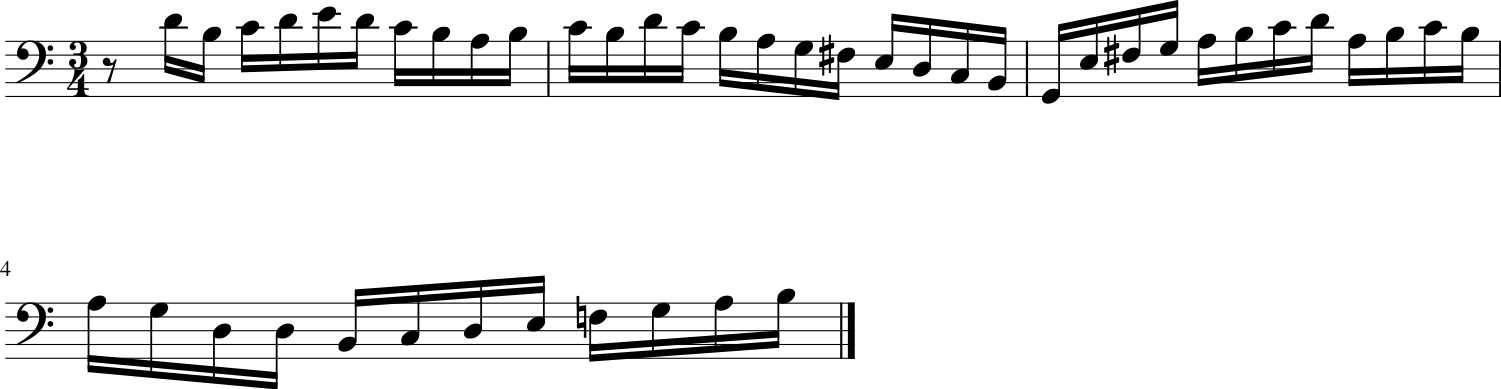

108/108 [==============================] - 15s 138ms/step - loss: 2.7190 - note_outputs_loss: 2.1731 - duration_outputs_loss: 0.5459
Epoch 27/50
[['START', '3/4TS', 'rest'], ['0.0', '0.0', '1.0']]- loss: 2.7080 - note_outputs_loss: 2.1558 - duration_outputs_loss: 0.5522 


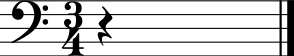

108/108 [==============================] - 9s 85ms/step - loss: 2.7080 - note_outputs_loss: 2.1558 - duration_outputs_loss: 0.5522
Epoch 28/50
[['START', '3/4TS', 'rest'], ['0.0', '0.0', '0.5']]- loss: 2.6747 - note_outputs_loss: 2.1303 - duration_outputs_loss: 0.5444 


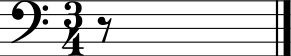

108/108 [==============================] - 9s 85ms/step - loss: 2.6747 - note_outputs_loss: 2.1303 - duration_outputs_loss: 0.5444
Epoch 29/50
[['START', '3/4TS', 'F#4', '3/4TS', 'C4', 'B-3', 'E-3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'B-2', 'G2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'D3', 'B-2', 'G#2', 'B-2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'G3', 'G#3', 'F3', 'G3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4', 'C#4', 'C4', 'B-3', 'G#3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


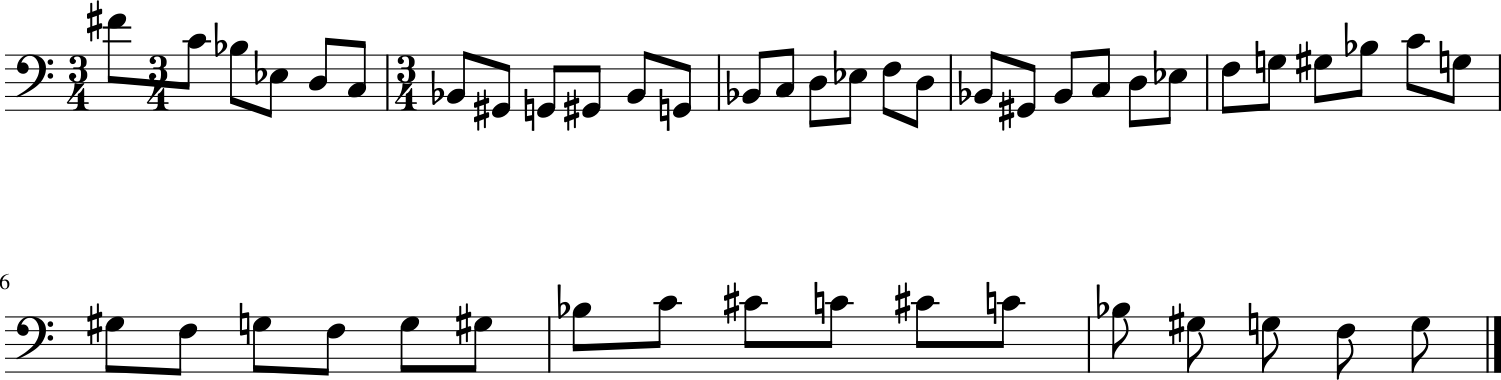

108/108 [==============================] - 15s 135ms/step - loss: 2.6555 - note_outputs_loss: 2.1139 - duration_outputs_loss: 0.5416
Epoch 30/50
[['START', '4/4TS', 'rest'], ['0.0', '0.5', '0.5']]- loss: 2.6648 - note_outputs_loss: 2.1071 - duration_outputs_loss: 0.5577 


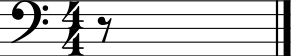

108/108 [==============================] - 9s 85ms/step - loss: 2.6648 - note_outputs_loss: 2.1071 - duration_outputs_loss: 0.5577
Epoch 31/50
[['START', '3/4TS', 'C4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'B3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'B-3', 'C4', 'B-3', 'A3', 'B-3', 'A3', 'B-3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


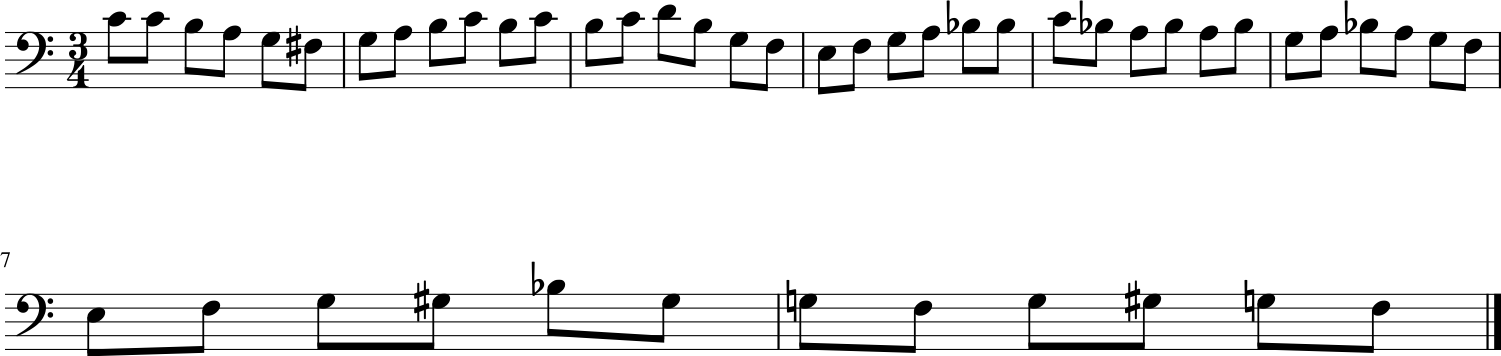

108/108 [==============================] - 15s 137ms/step - loss: 2.6228 - note_outputs_loss: 2.0823 - duration_outputs_loss: 0.5405
Epoch 32/50
[['START', '3/4TS', 'rest', 'rest', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'A3', 'F#3', 'A3', 'F#3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F#4', 'A3', 'A3', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'A3', 'C4', 'A3', 'F#3', 'A3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'C4', 'A3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


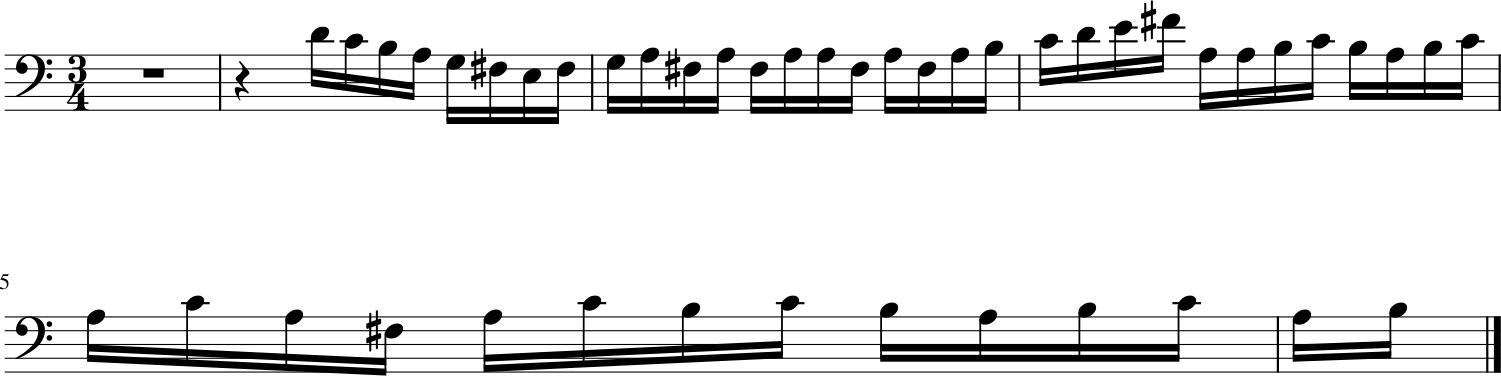

108/108 [==============================] - 16s 142ms/step - loss: 2.6216 - note_outputs_loss: 2.0772 - duration_outputs_loss: 0.5444
Epoch 33/50
[['START', '4/4TS', '3/4TS', 'rest', 'A3', 'C4', 'C4', 'A3', 'C4', 'B3', 'A3', 'G3', 'A3', 'B3', 'C4', 'A3', 'D4', 'E4', 'F#4', 'C4', 'C4', 'D4', 'A3', 'B3', 'C4', 'A3', 'D4', 'A3', 'B3', 'C4', 'D4', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'G3', 'A2', 'B2', 'C3', 'D3', 'B2', 'C3', 'D3'], ['0.0', '0.0', '0.0', '3.75', '0.25', '0.25', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


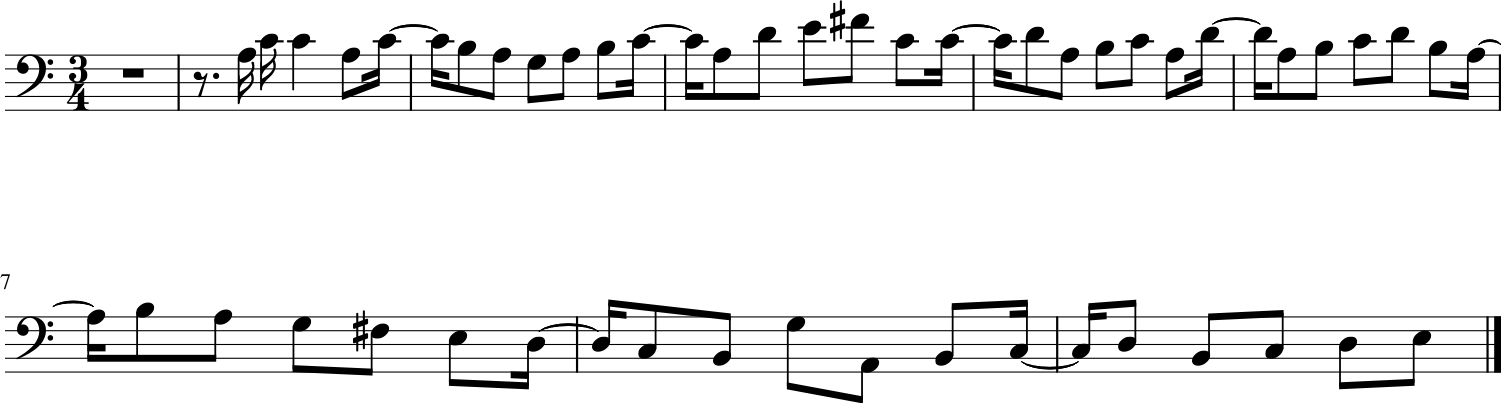

108/108 [==============================] - 15s 136ms/step - loss: 2.6045 - note_outputs_loss: 2.0586 - duration_outputs_loss: 0.5460
Epoch 34/50
[['START', '3/4TS', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'B-3', 'C4', 'C#4', 'C4'], ['0.0', '0.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


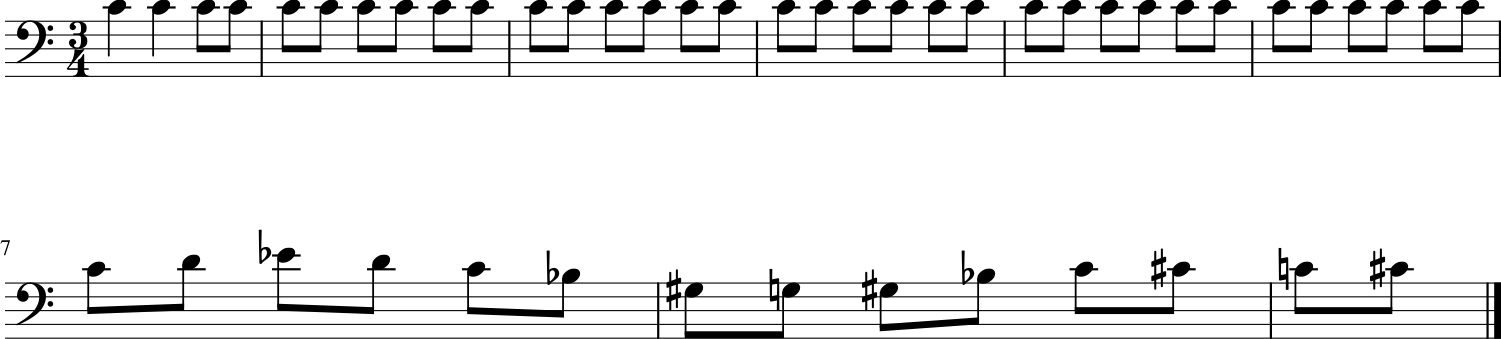

108/108 [==============================] - 15s 137ms/step - loss: 2.6018 - note_outputs_loss: 2.0548 - duration_outputs_loss: 0.5470
Epoch 35/50
[['START', '4/4TS', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'A4', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'D4', 'rest', 'rest', 'B3', 'A3', 'A3', 'rest', 'A3', 'rest', 'rest', 'rest', 'rest', 'rest', 'A4', 'A4', 'rest'], ['0.0', '3.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5']]


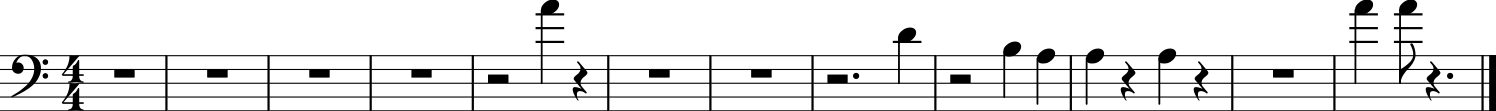

108/108 [==============================] - 15s 137ms/step - loss: 2.5872 - note_outputs_loss: 2.0489 - duration_outputs_loss: 0.5383
Epoch 36/50
[['START', '3/4TS', 'D3', 'C4', 'B3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'A2', 'B2', 'C3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'F#3', 'A3', 'B3', 'G3', 'D3', 'E3'], ['0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


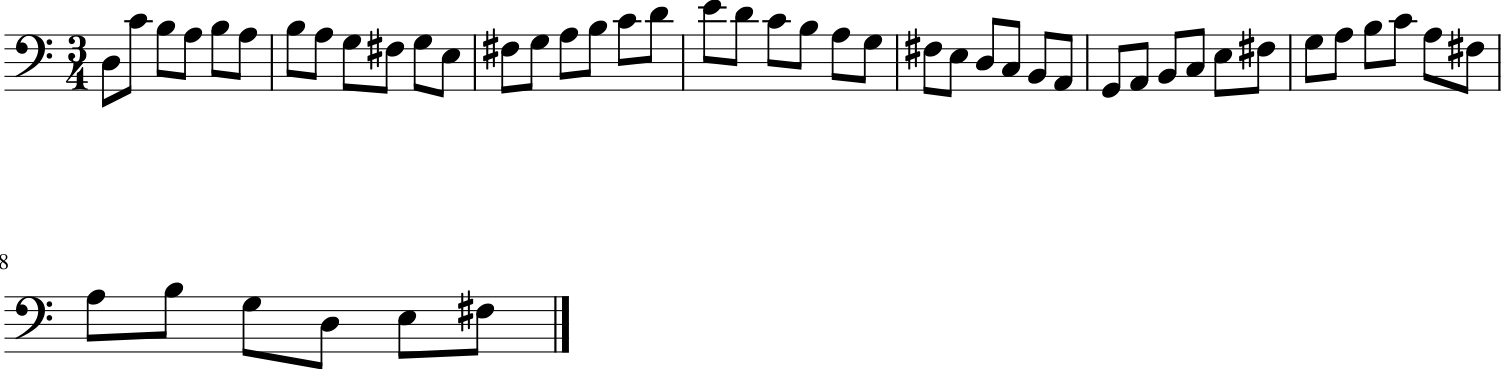

108/108 [==============================] - 15s 136ms/step - loss: 2.5807 - note_outputs_loss: 2.0246 - duration_outputs_loss: 0.5561
Epoch 37/50
[['START', '4/4TS', 'rest'], ['0.0', '0.0', '3.75']] loss: 2.5652 - note_outputs_loss: 2.0208 - duration_outputs_loss: 0.5444 


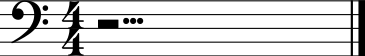

108/108 [==============================] - 9s 85ms/step - loss: 2.5652 - note_outputs_loss: 2.0208 - duration_outputs_loss: 0.5444
Epoch 38/50
[['START', '4/4TS', '4/4TS', 'rest', 'E-3', 'E-3', 'C3', 'D3', 'C3', 'B-2', 'G#2', 'G2', 'G#2', 'F2', 'G#2', 'D3', 'F3', 'B-2', 'G#2', 'C3', 'F3', 'G#2', 'G2', 'G#2', 'B-2', 'C3', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B2', 'C3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'G3', 'D3'], ['0.0', '0.0', '3.75', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


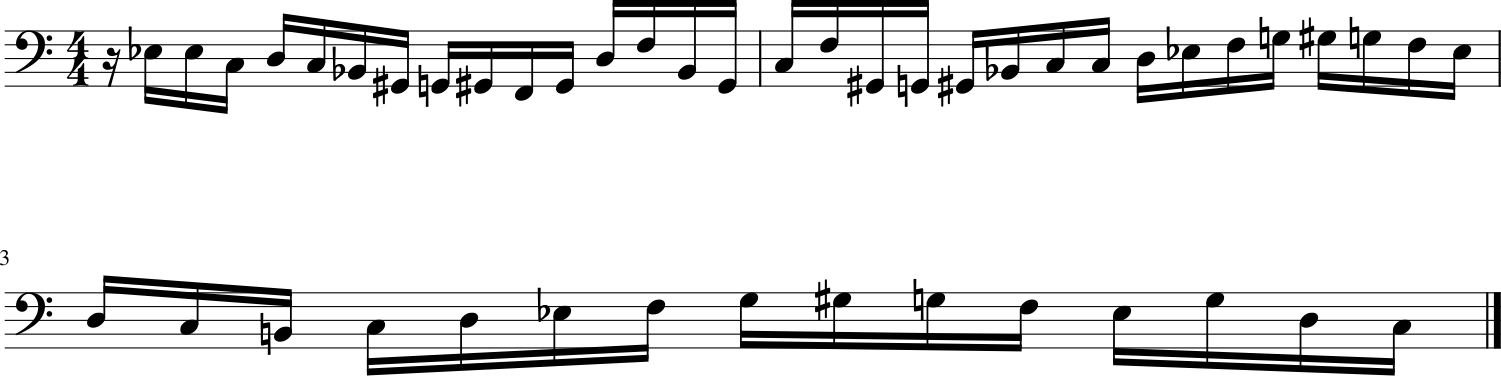

108/108 [==============================] - 15s 137ms/step - loss: 2.5315 - note_outputs_loss: 1.9944 - duration_outputs_loss: 0.5371
Epoch 39/50
[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'F3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3'], ['0.0', '0.0', '0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


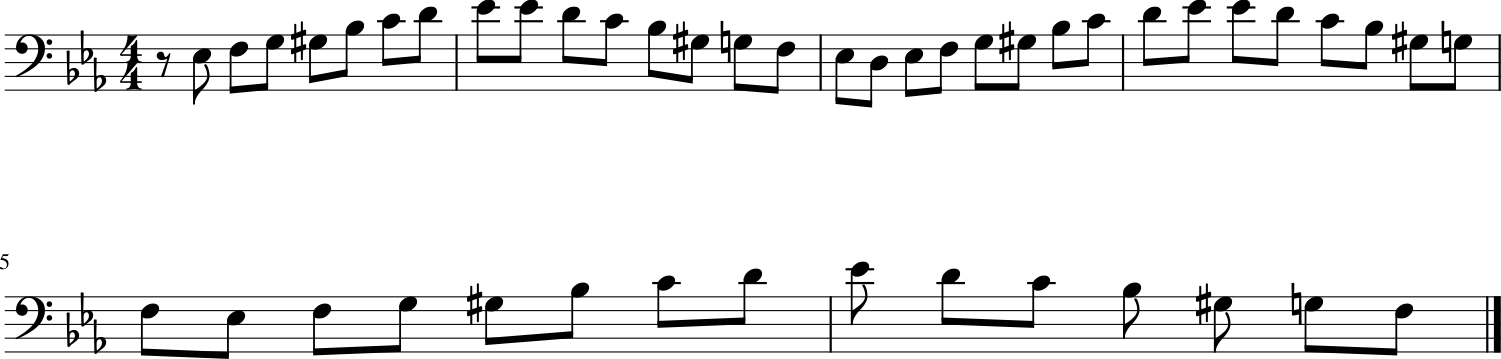

108/108 [==============================] - 15s 138ms/step - loss: 2.5426 - note_outputs_loss: 1.9951 - duration_outputs_loss: 0.5475
Epoch 40/50
[['START', '3/4TS', 'rest'], ['0.0', '3.75', '0.25']]loss: 2.5125 - note_outputs_loss: 1.9732 - duration_outputs_loss: 0.5394 


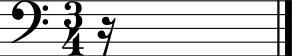

108/108 [==============================] - 9s 85ms/step - loss: 2.5125 - note_outputs_loss: 1.9732 - duration_outputs_loss: 0.5394
Epoch 41/50
[['START', '3/4TS', 'F2', 'G2', 'A2', 'F2', 'A3', 'A3', 'A3', 'F3', 'A3', 'F3', 'D3', 'F3', 'E3', 'D3', 'C3', 'B2', 'A2', 'B2', 'C3', 'A2', 'G2', 'E3', 'F3', 'D3', 'G#3', 'D3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3', 'D3', 'C#3', 'B2', 'A2', 'G2', 'A2', 'B2', 'C#3', 'D3', 'E3'], ['0.0', '0.0', '2.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


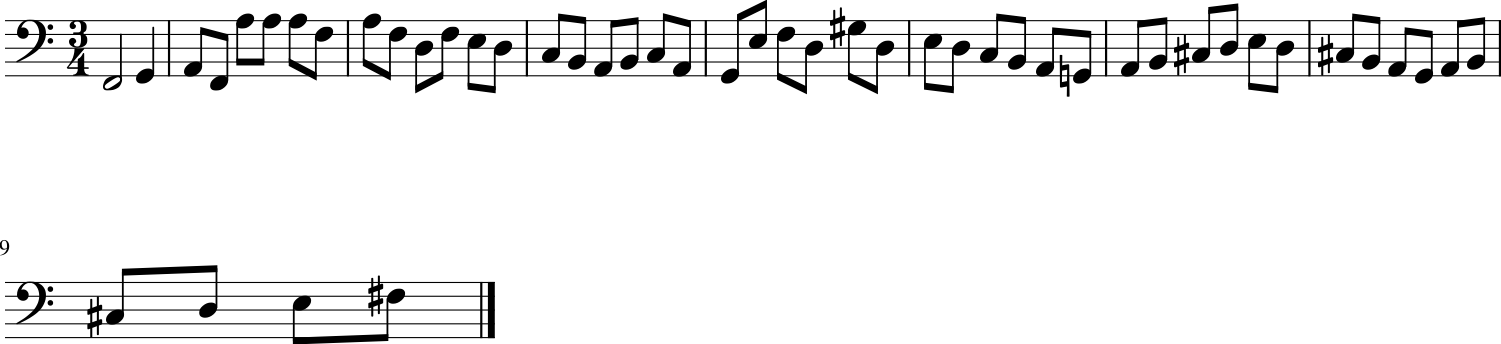

108/108 [==============================] - 15s 136ms/step - loss: 2.5094 - note_outputs_loss: 1.9643 - duration_outputs_loss: 0.5452
Epoch 42/50
[['START', '3/4TS', 'C4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'C4', 'D4', 'B3', 'B3', 'D4', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'E3', 'F#3', 'G3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'C4', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'C3', 'B2', 'A2', 'G2', 'A2', 'G2', 'A2', 'B2'], ['0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


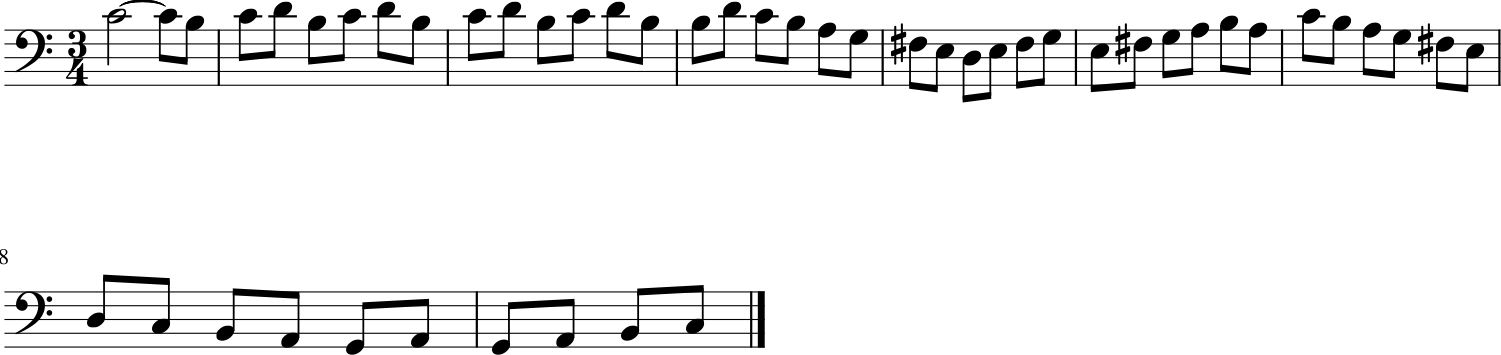

108/108 [==============================] - 15s 136ms/step - loss: 2.4787 - note_outputs_loss: 1.9435 - duration_outputs_loss: 0.5352
Epoch 43/50
[['START', '3/4TS', 'C4', 'A3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'C4', 'A3', 'B-3', 'G3', 'A3', 'F3', 'A3', 'G3', 'F3', 'E3', 'D3', 'C3', 'B-2', 'A2', 'C3', 'B-2', 'A2', 'B-2', 'D3', 'F3', 'B-3', 'B-3', 'A3', 'G3', 'F3', 'E-3', 'D3', 'C3', 'B-2', 'C3', 'D3', 'E-3', 'B-2', 'C3', 'D3'], ['0.0', '0.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


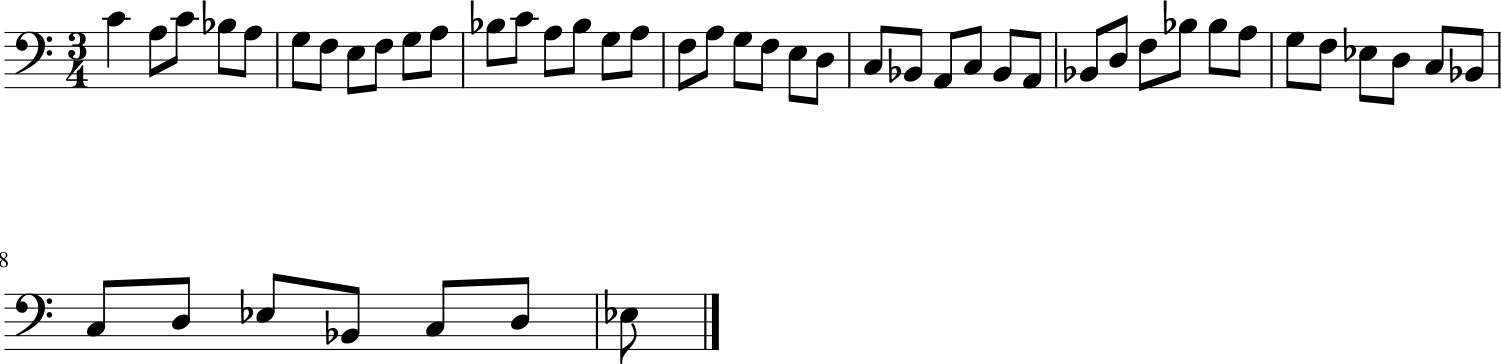

108/108 [==============================] - 15s 137ms/step - loss: 2.4657 - note_outputs_loss: 1.9270 - duration_outputs_loss: 0.5387
Epoch 44/50
[['START', '3/4TS', 'G3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3', 'E3', 'F3', 'D3', 'E3', 'F3', 'D3', 'E3', 'F3', 'E3', 'D3', 'E3', 'C3', 'G3', 'A3', 'B-3', 'A3', 'G3', 'F3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


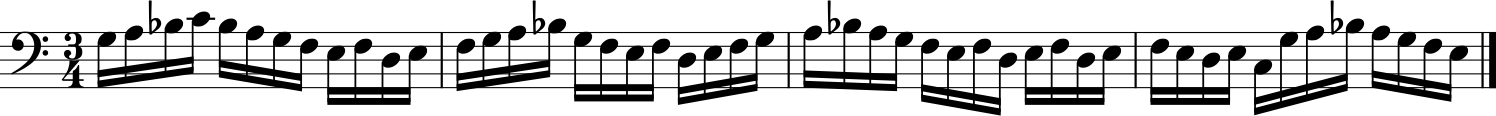

108/108 [==============================] - 15s 135ms/step - loss: 2.4637 - note_outputs_loss: 1.9199 - duration_outputs_loss: 0.5437
Epoch 45/50
[['START', '4/4TS', 'rest', 'D4', 'C#4', 'D4', 'E4', 'D4', 'C#4', 'rest', 'C#4', 'C#4', 'C#4', 'A4', 'G#4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'F#4', 'E4', 'D4', 'C#4', 'D4', 'B3', 'C#4', 'D4', 'C#4', 'B3', 'B3', 'C#4', 'D4', 'B3', 'C#4', 'D4', 'B3', 'C#4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


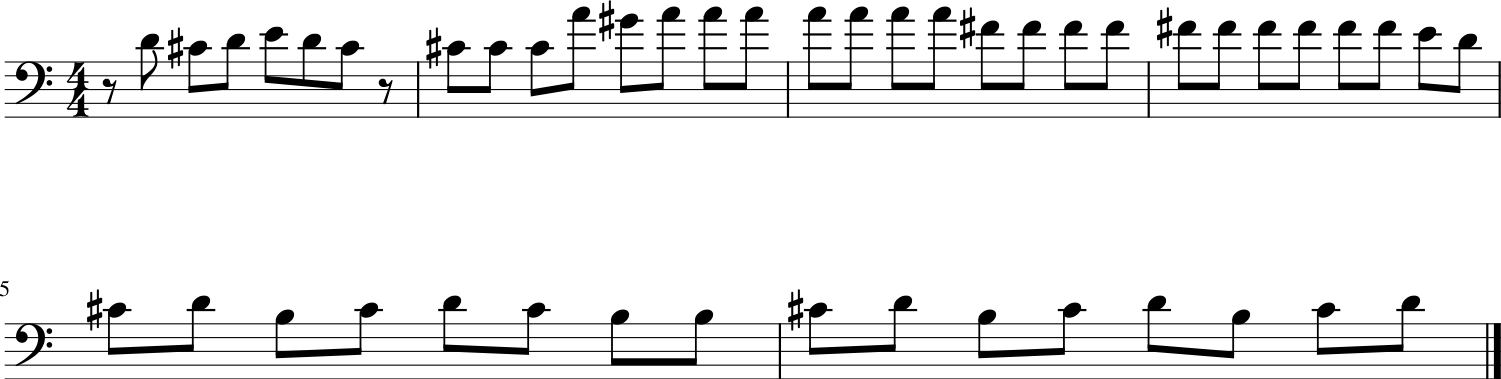

108/108 [==============================] - 15s 135ms/step - loss: 2.4506 - note_outputs_loss: 1.9122 - duration_outputs_loss: 0.5385
Epoch 46/50
[['START', '3/8TS', 'rest', 'G3', 'C4', 'C4', 'C4', 'C4', 'D4', 'G#3', 'G3', 'G#3', 'B-3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'C4', 'D4', 'E-4', 'D4', 'E-4', 'D4', 'C4', 'B-3', 'G#3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'G3', 'G#3', 'G#3', 'G3', 'F3', 'E-3', 'D3', 'E-3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


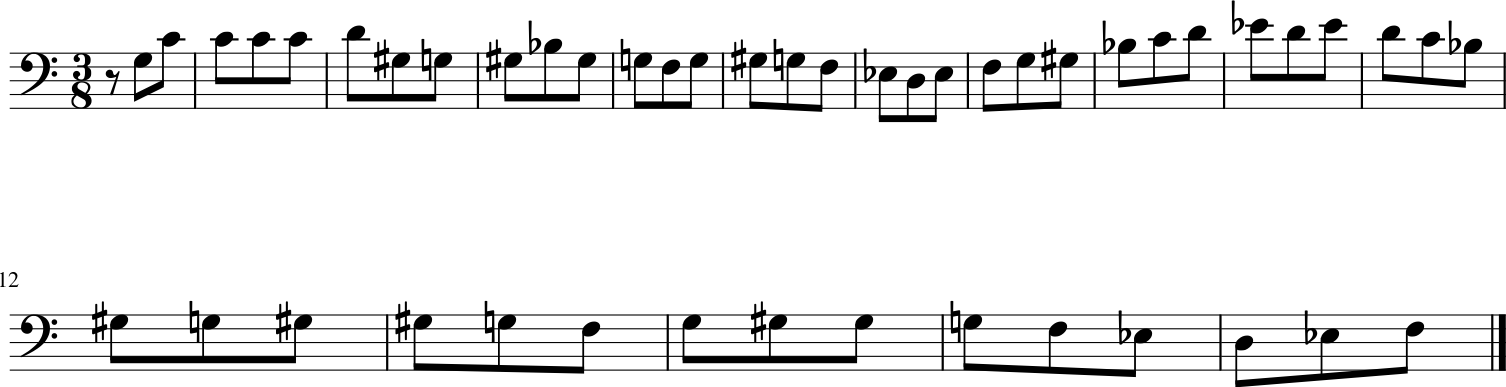

108/108 [==============================] - 15s 136ms/step - loss: 2.4313 - note_outputs_loss: 1.8982 - duration_outputs_loss: 0.5331
Epoch 47/50
[['START', '4/4TS', 'rest'], ['0.0', '0.0', '2.0']]- loss: 2.4423 - note_outputs_loss: 1.8910 - duration_outputs_loss: 0.5513 


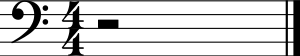

108/108 [==============================] - 10s 88ms/step - loss: 2.4423 - note_outputs_loss: 1.8910 - duration_outputs_loss: 0.5513
Epoch 48/50
[['START', '4/4TS', '3/8TS', 'rest', 'C4', 'C4', 'C4', 'C4', 'C4', 'G#3', 'C4', 'D3', 'C4', 'C4', 'C4', 'E3', 'F#3', 'G3', 'C3', 'D3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'C3', 'D3', 'C3', 'D3', 'C3', 'C3', 'C3', 'B2', 'A2', 'G2', 'F#2', 'A2', 'B2', 'C3', 'D3', 'B2', 'G2', 'A2', 'B2', 'C3', 'D3', 'E3', 'F#3', 'G3'], ['0.0', '1.0', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '0.5', '0.5', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']]


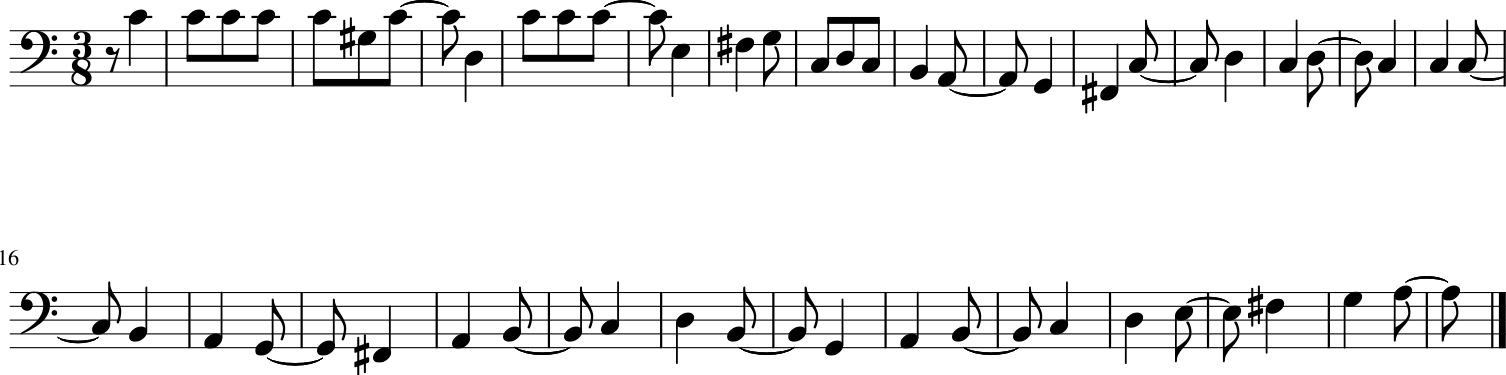

108/108 [==============================] - 15s 137ms/step - loss: 2.4316 - note_outputs_loss: 1.8876 - duration_outputs_loss: 0.5441
Epoch 49/50
[['START', '3/4TS', 'B-3', 'G3', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'A3', 'G3', 'F#3', 'G3', 'A3', 'B3', 'C4', 'A3', 'F#3', 'D3', 'F#3', 'G3', 'A3', 'B3', 'A3', 'B3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'A2', 'C#3', 'E3', 'A3', 'G3', 'F#3', 'E3', 'F#3', 'G3', 'A3', 'B3', 'C#4', 'D4', 'B3', 'C#4', 'D4', 'E4', 'F#4', 'G4'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


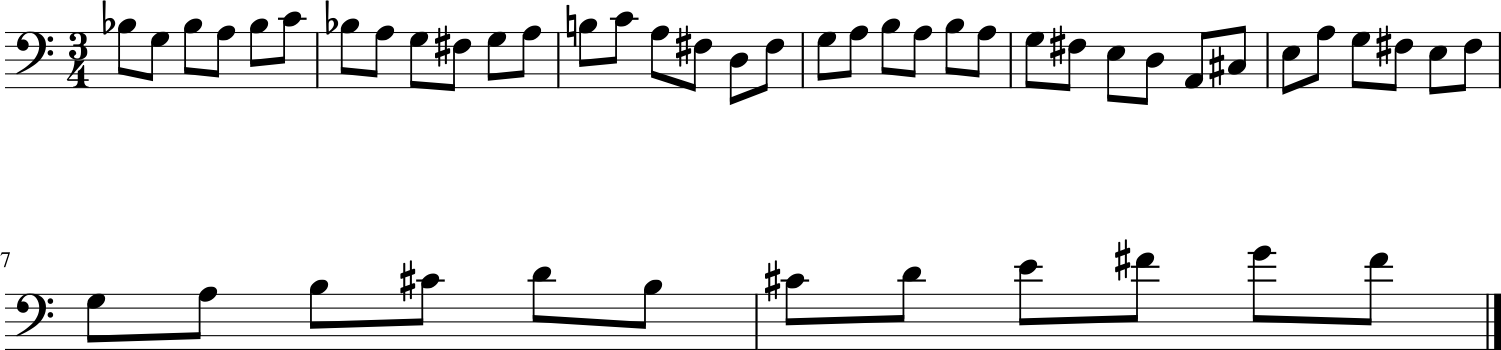

108/108 [==============================] - 15s 136ms/step - loss: 2.4018 - note_outputs_loss: 1.8581 - duration_outputs_loss: 0.5438
Epoch 50/50
[['START', '4/4TS', 'rest', 'A3', 'rest', 'A3', 'rest', 'G3', 'rest', 'A3', 'rest', 'G3', 'A3', 'G3', 'F#3', 'E3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3', 'D3'], ['0.0', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25', '0.25']]


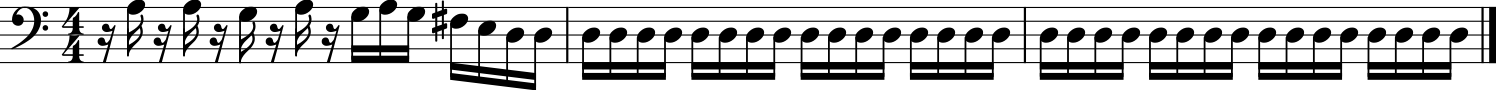

108/108 [==============================] - 15s 135ms/step - loss: 2.4002 - note_outputs_loss: 1.8549 - duration_outputs_loss: 0.5453


In [25]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator,
    ],
)

In [26]:
# Save the final model
model.save("./models/model")

INFO:tensorflow:Assets written to: ./models/model\assets


INFO:tensorflow:Assets written to: ./models/model\assets


# 3. Generate music using the Transformer

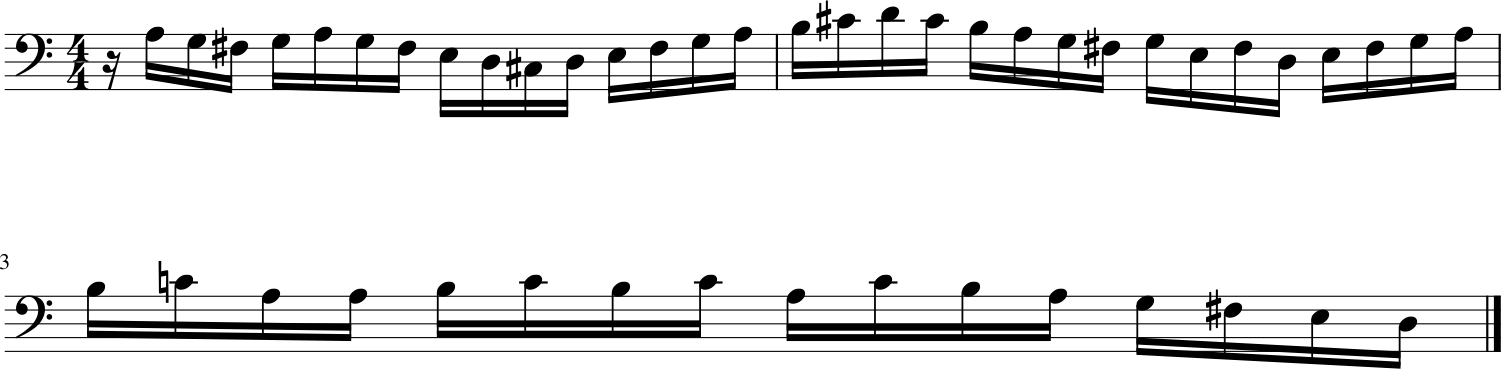

In [27]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [28]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "../../../notebooks/11_music/01_transformer/output",
        "output-" + timestr + ".mid",
    ),
)

'../../../notebooks/11_music/01_transformer/output\\output-20250602-134652.mid'

## Note probabilities

In [29]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

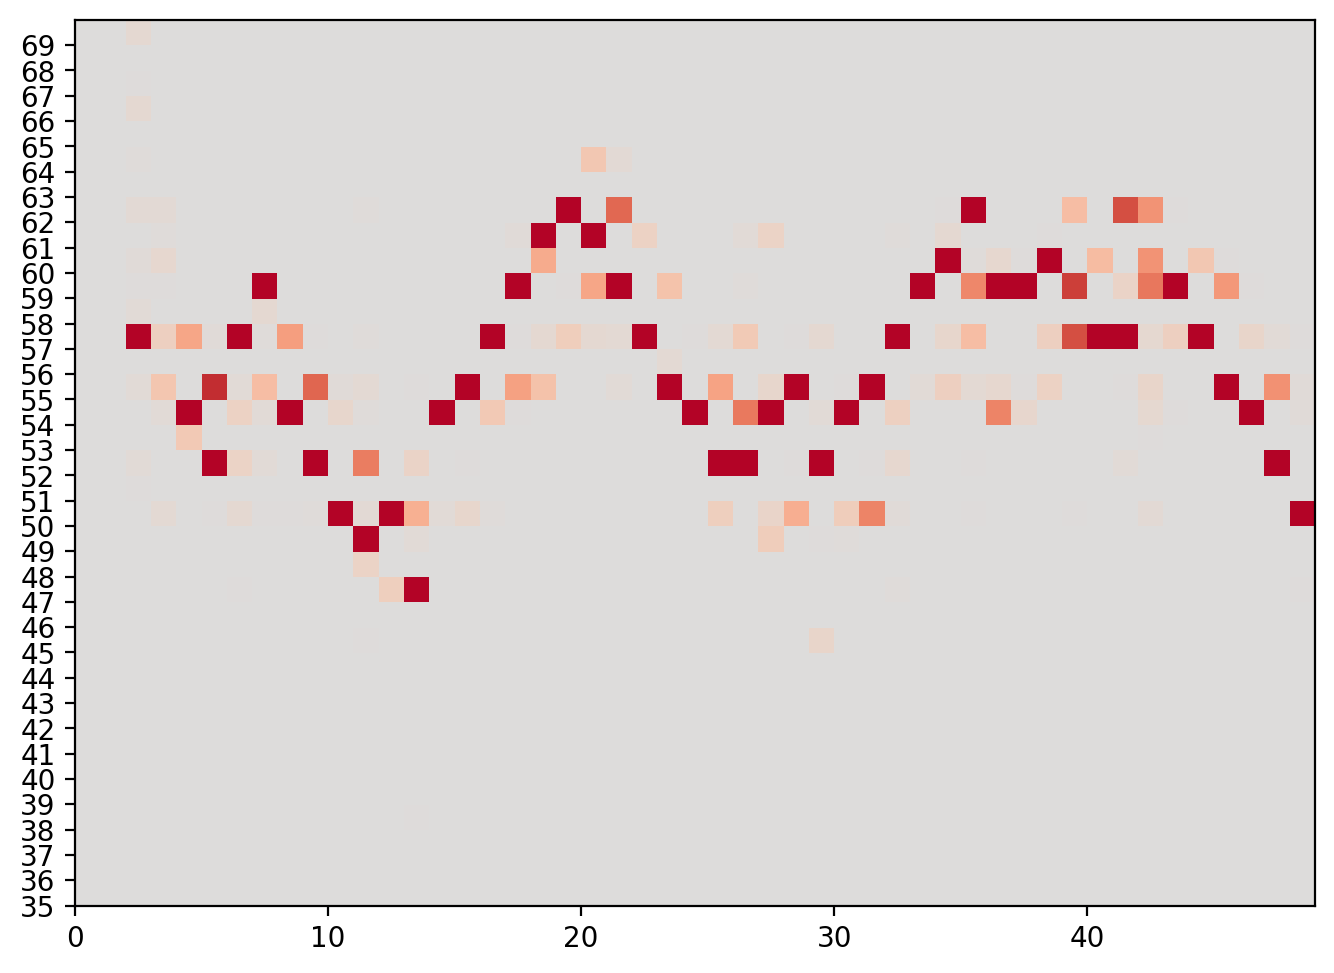

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

## Attention Plot

In [31]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [32]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

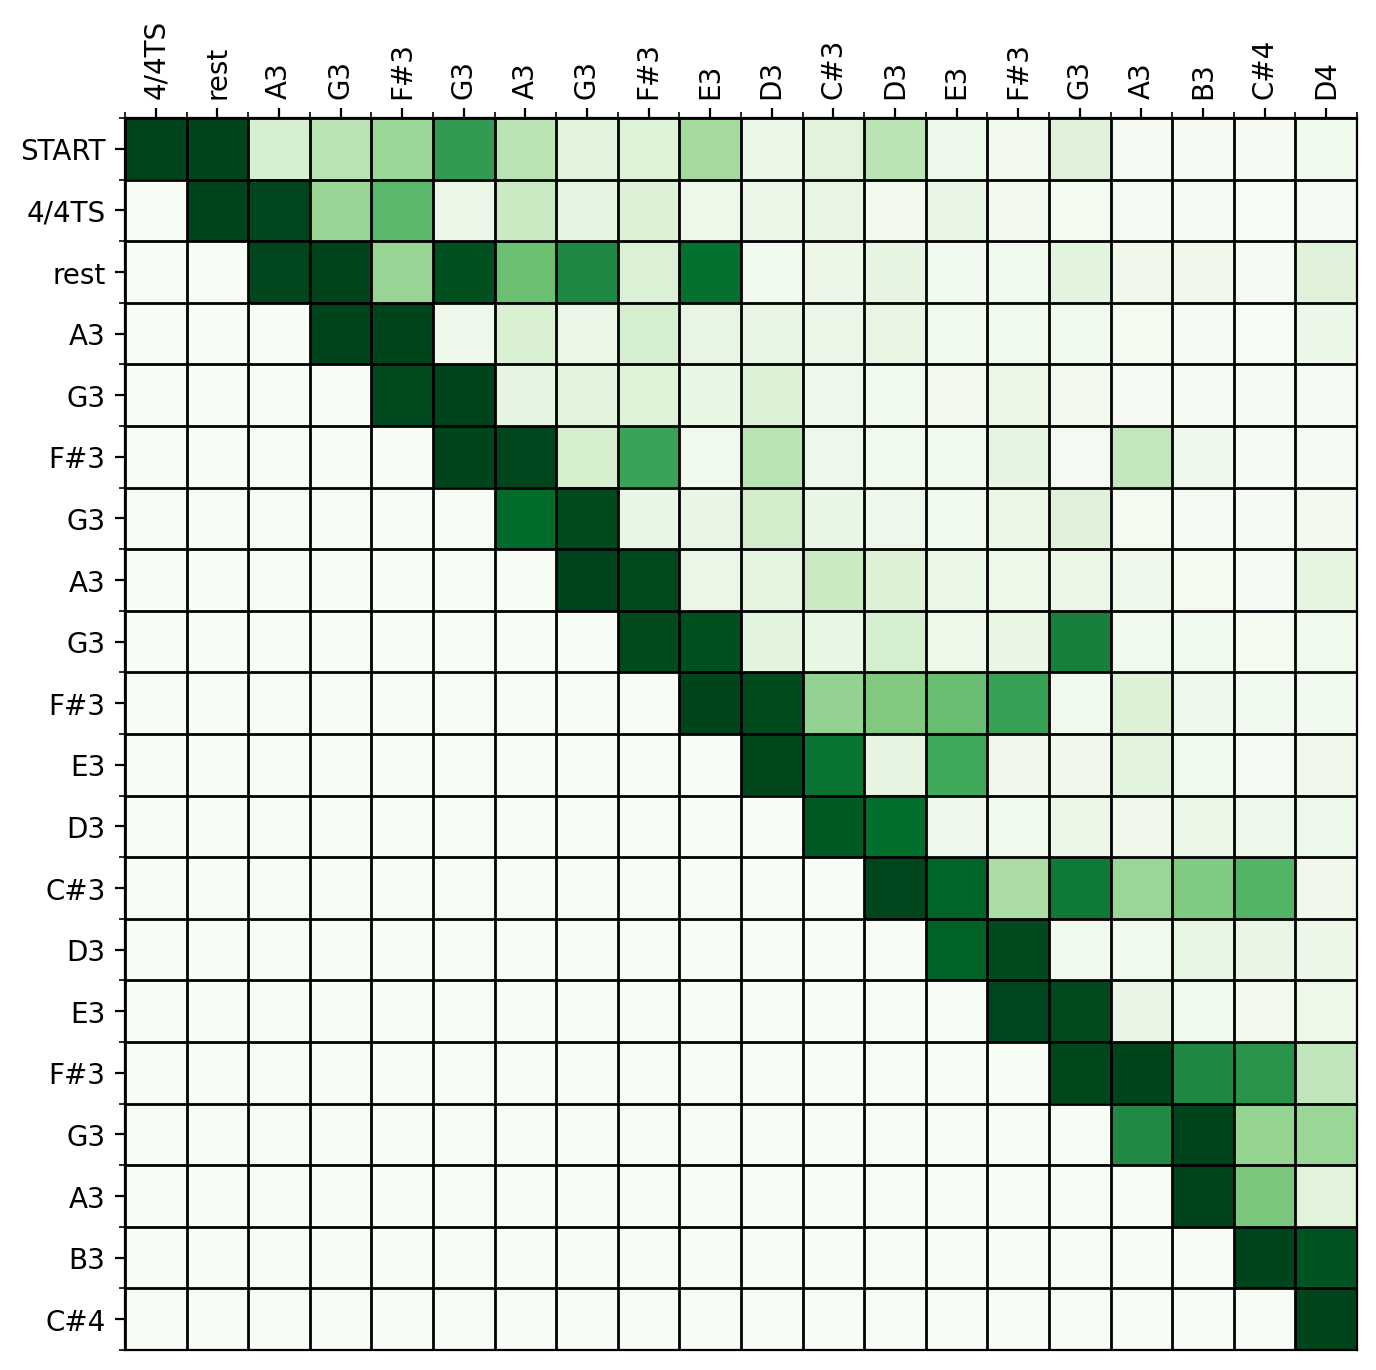

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()